### remember to change model saving path!!!

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm
import random
import torch.nn as nn
from dataset import Thyroid_Dataset
from model import Eff_Unet
from HarDMSEG import HarDMSEG
from loss_metric import DiceLoss, IOU_score, StructureLoss, TverskyLoss
from LightMed.model.LightMed import LightMed
from PMFSNet.lib.models.PMFSNet import PMFSNet
from PMFSNet.lib.models.PMFSNet_FFT import PMFSNet_FFT
from hybrid_model_v3 import HybridSegModel

/home/twszbak764/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/twszbak764/.local/lib/python3.12/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


In [2]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
import wandb
wandb.login()

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


True

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
from torchvision import transforms
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms.functional as tx
import random
import cv2
from PIL import ImageEnhance
from skimage.exposure import match_histograms
import torchvision.transforms as T
import torchvision.transforms.functional as F
class Ge_Benq_Dataset(Dataset):
    def __init__(self, csv_file, transform, image_size, training = True):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.image_size = image_size
        self.training = training
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_name = self.df["image_name"][idx]
        mask_name = self.df["mask_name"][idx]
        dataset = self.df["dataset"][idx]
        if dataset=="ge":
            from_dataset = 1
        else:
            from_dataset = 2
        if dataset == "benq":
            from_folder = "../gland_data"
        else:
            if self.training:
                from_folder = "../ge_data/train"
            else:
                from_folder = "../ge_data/test"
        
        image_path = f"{from_folder}/images/{image_name}"
        mask_path = f"{from_folder}/masks/{mask_name}"

        image = Image.open(image_path).convert("L")
        mask = Image.open(mask_path).convert("L")
        
        image_tensor, mask_tensor = self.transform(image, mask, self.image_size)
        mask_tensor = (mask_tensor > 0.5).float()
        if torch.sum(mask_tensor) == 0:
            # print("nothing")
            return [None]
        return image_tensor, mask_tensor, from_dataset

In [5]:
image_size = 128
batch_size = 128
def train_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    p = 0.7
    
    # if(random.random() < p):
    #     jitter = T.ColorJitter(brightness = 0.5, contrast = 0.25)
    #     image = jitter(image)
    # if(random.random() < p):
    #     transform = T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
    #     image = transform(image)  # image must be a PIL image
    if(random.random() < p):
        # angle = random.uniform(-10, 10)  # 旋轉角度從 ±10 度
        angle = 0.0
        max_dx = 0.05  # 水平平移比例
        max_dy = 0.3  # 垂直平移比例
        translate_x = random.uniform(-max_dx, max_dx) * image.size[0]
        translate_y = random.uniform(-max_dy, max_dy) * image.size[1]
        translate = (int(translate_x), int(translate_y))
        scale = random.uniform(0.9, 1.6)  # 尺度縮放 ±5%
        # scale = 1.0
        # shear = [random.uniform(-5, 5), random.uniform(-5, 5)]  # 小幅剪切
        shear=[0.0, 0.0]
        image = F.affine(image, angle=angle, translate=translate, scale=scale, shear=shear)
        mask = F.affine(mask, angle=angle, translate=translate, scale=scale, shear=shear)

        
    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def test_augmentation(image, mask, image_size):
    resize = T.Resize((image_size, image_size))
    image = resize(image)
    mask = resize(mask)

    image_tensor = tx.to_tensor(image)
    mask_tensor = tx.to_tensor(mask)

    # If standardization
    mean = image_tensor.mean()
    std = image_tensor.std()
    std = std if std > 0 else 1.0  # avoid division by zero
    image_tensor = (image_tensor - mean) / std
    return image_tensor, mask_tensor
def custom_collate_fn(batch):
    # print(batch)
    filtered_batch = [item for item in batch if item[0] is not None]
    if len(filtered_batch) == 0:
        return [None, None]
    return torch.utils.data.dataloader.default_collate(filtered_batch)
train_dataset = Ge_Benq_Dataset("../ge_benq_data/ge_benq_train.csv", transform = train_augmentation, image_size = image_size)
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, collate_fn=custom_collate_fn)

test_dataset = Ge_Benq_Dataset("../ge_benq_data/ge_benq_test.csv", transform = test_augmentation, image_size = image_size, training = False)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, collate_fn=custom_collate_fn)

image, mask, from_dataset = next(iter(test_dataloader))

In [6]:
from_dataset==1

tensor([ True, False, False,  True,  True,  True,  True, False, False, False,
        False,  True, False,  True,  True,  True,  True,  True, False, False,
         True,  True,  True, False,  True,  True, False,  True, False, False,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True, False,  True,  True,  True, False,  True,  True, False, False,
        False,  True,  True,  True,  True, False,  True, False, False,  True,
         True, False,  True, False,  True, False, False,  True, False, False,
         True,  True,  True,  True, False, False, False,  True,  True,  True,
         True,  True,  True, False, False, False,  True,  True,  True,  True,
        False, False,  True,  True,  True,  True,  True, False,  True, False,
        False, False,  True,  True, False])

In [7]:
print(len(train_dataset), len(test_dataset))

719 191


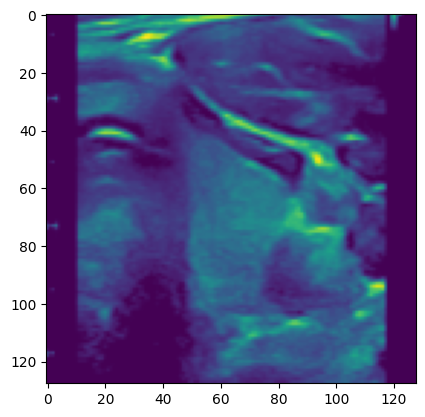

In [8]:
plt.imshow(image[18][0])

In [9]:
def train(dataloader, model, optimizer, loss_fn, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0
    ge_IOU = 0
    benq_IOU = 0
    ge_DICE = 0
    benq_DICE = 0
    
    model.train()
    model.to(device)
    count = 0
    for image, mask, from_dataset in tqdm(dataloader):
        if image == None:
            continue
        image, mask = image.to(device), mask.to(device)
        
        outputs = model(image)
        
        nodule_output = outputs[:, 0:1, :, :]
        gland_output = outputs[:, 1:2, :, :]

        ge_output = nodule_output[from_dataset==1]
        benq_output = gland_output[from_dataset==2]
        ge_mask = mask[from_dataset==1]
        benq_mask = mask[from_dataset==2]
        
        ge_loss = loss_fn(ge_output, ge_mask)
        benq_loss = loss_fn(benq_output, benq_mask)
        loss = (ge_loss * 0.7 + benq_loss * 0.3) / 2



        ge_iou = IOU_score(ge_output, ge_mask)
        benq_iou = IOU_score(benq_output, benq_mask)
        IOU = (ge_iou + benq_iou) / 2

        dice_loss = DiceLoss()
        
        ge_dice = 1 - dice_loss(ge_output, ge_mask)
        benq_dice = 1 - dice_loss(benq_output, benq_mask)
        DICE = (ge_dice + benq_dice) / 2
        

        
        # Backward and optimize
        optimizer.zero_grad()   # clear previous gradients
        loss.backward()         # compute gradients
        optimizer.step()        # update weights

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()

        ge_IOU += ge_iou.item()
        benq_IOU += benq_iou.item()
        ge_DICE += ge_dice.item()
        benq_DICE += benq_dice.item()
        count+=1

    return total_loss/count, total_IOU/count, total_DICE/count, ge_IOU/count, benq_IOU/count, ge_DICE/count, benq_DICE/count


# 
# Only calculate nodule loss, IOU, DICE, because there is no gland data in the testing set
def val(dataloader, model, loss_fn, device):
    total_loss = 0
    total_IOU = 0
    total_DICE = 0
    ge_IOU = 0
    benq_IOU = 0
    ge_DICE = 0
    benq_DICE = 0
    
    model.eval()
    model.to(device)
    count = 0
    for image, mask, from_dataset in tqdm(dataloader):
        if image == None:
            continue
        image, mask = image.to(device), mask.to(device)
        
        outputs = model(image)
        
        nodule_output = outputs[:, 0:1, :, :]
        gland_output = outputs[:, 1:2, :, :]

        ge_output = nodule_output[from_dataset==1]
        benq_output = gland_output[from_dataset==2]
        ge_mask = mask[from_dataset==1]
        benq_mask = mask[from_dataset==2]

        ge_loss = loss_fn(ge_output, ge_mask)
        benq_loss = loss_fn(benq_output, benq_mask)
        loss = (ge_loss + benq_loss) / 2



        ge_iou = IOU_score(ge_output, ge_mask)
        benq_iou = IOU_score(benq_output, benq_mask)
        IOU = (ge_iou + benq_iou) / 2

        dice_loss = DiceLoss()
        
        ge_dice = 1 - dice_loss(ge_output, ge_mask)
        benq_dice = 1 - dice_loss(benq_output, benq_mask)
        DICE = (ge_dice + benq_dice) / 2
        

        

        total_loss += loss.item()
        total_IOU += IOU.item()
        total_DICE += DICE.item()

        ge_IOU += ge_iou.item()
        benq_IOU += benq_iou.item()
        ge_DICE += ge_dice.item()
        benq_DICE += benq_dice.item()
        count+=1

    return total_loss/count, total_IOU/count, total_DICE/count, ge_IOU/count, benq_IOU/count, ge_DICE/count, benq_DICE/count


    

In [10]:

inference_name = "models/Phase 1/Hybrid_crop_DDTI_standardization_aug_affine(0.5)_for_gland"

model = HybridSegModel(in_channels = 1, out_channels = 2, output_size = image_size, layers_num = 3)
checkpoint = torch.load(f"{inference_name}/best_checkpoint.pth")
model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

<All keys matched successfully>

In [11]:
# freeze encoder
for param in model.backbone.parameters():
    param.requires_grad = False

In [12]:

epochs = 500
lr = 0.005
loss_fn = StructureLoss()
# loss_fn = TverskyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.AdamW(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [14]:

project = "thyroid_ge_benq_finetune"
name = "hybrid_model_ge_benq(crop)_baseline(1)_freeze_encoder_wo_zeromask_aug_space_loss_adjust_v2"

wandb.init(
    project = project,  # Project name in W&B
    name = name,       # (optional) specific run name
    config={                     # (optional) hyperparameters
        "image_size": image_size,
        "learning_rate": lr,
        "epochs": epochs,
        "batch_size": batch_size,
        # "weight_decay":1e-4
    }
)

wandb: Currently logged in as: s960068sss (s960068sss-ucl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [15]:
print(f"image size : {image_size}, lr : {lr}, epochs : {epochs}, batch size : {batch_size}")

image size : 128, lr : 0.005, epochs : 500, batch size : 128


In [ ]:
max_IOU = -1
for epoch in range(epochs):
    print(f"epoch : {epoch}")
    total_loss_train, total_IOU_train, total_DICE_train, ge_IOU_train, benq_IOU_train, ge_DICE_train, benq_DICE_train = train(train_dataloader, model, optimizer, loss_fn, "cuda")
    print(f"train loss : {total_loss_train}, train IOU : {total_IOU_train}, train DICE : {total_DICE_train}")
    total_loss_val, total_IOU_val, total_DICE_val, ge_IOU_val, benq_IOU_val, ge_DICE_val, benq_DICE_val = val(test_dataloader, model, loss_fn, "cuda")
    print(f"val loss : {total_loss_val}, val IOU : {total_IOU_val}, val DICE : {total_DICE_val}")
    
    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]



    if max_IOU < total_IOU_val:
        max_IOU = total_IOU_val
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            "IOU" : total_IOU_val,
            "DICE" : total_DICE_val,
            "loss" : total_loss_val
        }
        folder = f"models/finetune/ge_benq/{name}/"
        if not os.path.exists(folder):
            os.mkdir(folder)
        torch.save(checkpoint, f"models/finetune/ge_benq/{name}/best_checkpoint.pth")

    
    wandb.log({
        "epoch": epoch,
        "Learning Rate":current_lr,
        
        "train_loss": total_loss_train,
        "train_IOU": total_IOU_train,
        "train_DICE": total_DICE_train,
        "train_ge_IOU" : ge_IOU_train,
        "train_ge_DICE" : ge_DICE_train,
        "train_benq_IOU" : benq_IOU_train,
        "train_benq_DICE" : benq_DICE_train,
        
        "val_loss": total_loss_val,
        "val_IOU": total_IOU_val,
        "val_DICE": total_DICE_val,
        "val_ge_IOU" : ge_IOU_val,
        "val_ge_DICE" : ge_DICE_val,
        "val_benq_IOU" : benq_IOU_val,
        "val_benq_DICE" : benq_DICE_val,
        
    })




checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    "IOU" : total_IOU_val,
    "DICE" : total_DICE_val,
    "loss" : total_loss_val
}
torch.save(checkpoint, f"models/finetune/ge_benq/{name}/last_checkpoint.pth")
wandb.finish()

epoch : 0


/home/twszbak764/miniconda3/envs/thyroid/lib/python3.12/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 6/6 [00:21<00:00,  3.60s/it]


train loss : 0.3744933009147644, train IOU : 0.528682162364324, train DICE : 0.670667419830958


100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


val loss : 0.5824598371982574, val IOU : 0.639415830373764, val DICE : 0.7506665885448456
epoch : 1


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.30160507559776306, train IOU : 0.5923032363255819, train DICE : 0.7183545827865601


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.5369457006454468, val IOU : 0.6498622894287109, val DICE : 0.7656759023666382
epoch : 2


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.27382224798202515, train IOU : 0.6192507843176523, train DICE : 0.731961319843928


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.5500380098819733, val IOU : 0.6501568257808685, val DICE : 0.7583448886871338
epoch : 3


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.26931072771549225, train IOU : 0.6239432295163473, train DICE : 0.7373411953449249


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.508508563041687, val IOU : 0.6570959687232971, val DICE : 0.7653236389160156
epoch : 4


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.25160931795835495, train IOU : 0.6426211694876353, train DICE : 0.7508047421773275


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.50408536195755, val IOU : 0.6534043252468109, val DICE : 0.749271810054779
epoch : 5


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.23908861229817072, train IOU : 0.6467012266318003, train DICE : 0.7552477717399597


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.4781814515590668, val IOU : 0.6701932847499847, val DICE : 0.7653138041496277
epoch : 6


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.2378635754187902, train IOU : 0.6686336596806844, train DICE : 0.7634537021319071


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.46496690809726715, val IOU : 0.672299325466156, val DICE : 0.7707479000091553
epoch : 7


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.23466311891873678, train IOU : 0.6691899597644806, train DICE : 0.766814778248469


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.46964678168296814, val IOU : 0.6721497476100922, val DICE : 0.7644723057746887
epoch : 8


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.22515040139357248, train IOU : 0.6747552653153738, train DICE : 0.7783864637215933


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


val loss : 0.4644755572080612, val IOU : 0.6803045272827148, val DICE : 0.7674365341663361
epoch : 9


100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


train loss : 0.2197538564602534, train IOU : 0.6880963444709778, train DICE : 0.7806193828582764


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.46120914816856384, val IOU : 0.6836484670639038, val DICE : 0.7720999121665955
epoch : 10


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.22145218153794607, train IOU : 0.6834171414375305, train DICE : 0.780118981997172


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.46195994317531586, val IOU : 0.6874186098575592, val DICE : 0.7698772549629211
epoch : 11


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.21632364143927893, train IOU : 0.6930865347385406, train DICE : 0.7840691010157267


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.4496699571609497, val IOU : 0.6906303465366364, val DICE : 0.7749675512313843
epoch : 12


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.21568352729082108, train IOU : 0.6986130674680074, train DICE : 0.7899301052093506


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.4493402987718582, val IOU : 0.6854598522186279, val DICE : 0.7729455232620239
epoch : 13


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.21139495819807053, train IOU : 0.7037860155105591, train DICE : 0.7920522193113962


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.44881002604961395, val IOU : 0.6954604983329773, val DICE : 0.7756431698799133
epoch : 14


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.20456852515538534, train IOU : 0.7102726101875305, train DICE : 0.7974292635917664


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


val loss : 0.4375946819782257, val IOU : 0.7004030644893646, val DICE : 0.7848363220691681
epoch : 15


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.2041854535539945, train IOU : 0.709570566813151, train DICE : 0.8016421298185984


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.45549917221069336, val IOU : 0.687344491481781, val DICE : 0.7738477289676666
epoch : 16


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.2034724901119868, train IOU : 0.7092508574326833, train DICE : 0.7975238561630249


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.44099217653274536, val IOU : 0.6949526369571686, val DICE : 0.7832444310188293
epoch : 17


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.20137121031681696, train IOU : 0.7225152750809988, train DICE : 0.8072660168011984


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.4538631737232208, val IOU : 0.6861050128936768, val DICE : 0.7738465070724487
epoch : 18


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.2004001041253408, train IOU : 0.7169470489025116, train DICE : 0.8045592804749807


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4706434905529022, val IOU : 0.6804715991020203, val DICE : 0.7655054330825806
epoch : 19


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.19880787034829459, train IOU : 0.7181089123090109, train DICE : 0.8063663144906362


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4514137953519821, val IOU : 0.6870768070220947, val DICE : 0.7821808457374573
epoch : 20


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.19011876980463663, train IOU : 0.7320392827192942, train DICE : 0.8174994985262553


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.44085633754730225, val IOU : 0.6979012191295624, val DICE : 0.7841949164867401
epoch : 21


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.18914338946342468, train IOU : 0.7339218358198801, train DICE : 0.8184270759423574


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.43627288937568665, val IOU : 0.7016641497612, val DICE : 0.788604736328125
epoch : 22


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.19364703198273978, train IOU : 0.7313929796218872, train DICE : 0.8145168721675873


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.43383726477622986, val IOU : 0.7037559747695923, val DICE : 0.789684385061264
epoch : 23


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.18295240153868994, train IOU : 0.7430430253346761, train DICE : 0.8260682622591654


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.42702244222164154, val IOU : 0.70395827293396, val DICE : 0.7913969159126282
epoch : 24


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.18559182186921439, train IOU : 0.7358470261096954, train DICE : 0.8209169606367747


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.45333389937877655, val IOU : 0.6954019069671631, val DICE : 0.7816829085350037
epoch : 25


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.18730021516482034, train IOU : 0.7403524617354075, train DICE : 0.8222104410330454


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


val loss : 0.44576430320739746, val IOU : 0.6973925530910492, val DICE : 0.7839167416095734
epoch : 26


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.1898641362786293, train IOU : 0.7409113446871439, train DICE : 0.8230922818183899


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.4334559589624405, val IOU : 0.7013922035694122, val DICE : 0.7938011884689331
epoch : 27


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.17998993893464407, train IOU : 0.7498693068822225, train DICE : 0.8296750783920288


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.43401363492012024, val IOU : 0.7026064991950989, val DICE : 0.7909532189369202
epoch : 28


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.18148264040549597, train IOU : 0.7354392111301422, train DICE : 0.8251319527626038


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.4336463212966919, val IOU : 0.7017041146755219, val DICE : 0.7906246185302734
epoch : 29


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.1819847896695137, train IOU : 0.7519599000612894, train DICE : 0.8274815877278646


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.41973306238651276, val IOU : 0.7023509740829468, val DICE : 0.7965922355651855
epoch : 30


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.1862510566910108, train IOU : 0.7408547500769297, train DICE : 0.8220969537893931


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.44857724010944366, val IOU : 0.7002618312835693, val DICE : 0.783675491809845
epoch : 31


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.17946604639291763, train IOU : 0.745307207107544, train DICE : 0.8306835889816284


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.423541784286499, val IOU : 0.7092782258987427, val DICE : 0.7982192635536194
epoch : 32


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.17111985137065253, train IOU : 0.7615647614002228, train DICE : 0.8385141889254252


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.43175068497657776, val IOU : 0.7035802602767944, val DICE : 0.7955214977264404
epoch : 33


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.17005802939335504, train IOU : 0.7641484340031942, train DICE : 0.8418602049350739


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.43263739347457886, val IOU : 0.7005281746387482, val DICE : 0.7927744388580322
epoch : 34


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.17469866077105203, train IOU : 0.754864901304245, train DICE : 0.8375672002633413


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


val loss : 0.4335256367921829, val IOU : 0.7068369388580322, val DICE : 0.7954408228397369
epoch : 35


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.16842489937941232, train IOU : 0.7690675854682922, train DICE : 0.8409874637921652


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.435501366853714, val IOU : 0.7022521793842316, val DICE : 0.7944670915603638
epoch : 36


100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


train loss : 0.16581092278162637, train IOU : 0.7701499164104462, train DICE : 0.8470248977343241


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


val loss : 0.4260900318622589, val IOU : 0.7040450870990753, val DICE : 0.7972694039344788
epoch : 37


100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


train loss : 0.16723844408988953, train IOU : 0.765339732170105, train DICE : 0.8433754046758016


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


val loss : 0.44430801272392273, val IOU : 0.6959739923477173, val DICE : 0.7874802947044373
epoch : 38


100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


train loss : 0.16637904196977615, train IOU : 0.7694297333558401, train DICE : 0.8462956448396047


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


val loss : 0.45195481181144714, val IOU : 0.6962018609046936, val DICE : 0.784062385559082
epoch : 39


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.16935987770557404, train IOU : 0.7655381262302399, train DICE : 0.8417793313662211


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.42646248638629913, val IOU : 0.7054252922534943, val DICE : 0.7997910976409912
epoch : 40


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.16573699315388998, train IOU : 0.7674820919831594, train DICE : 0.8456424574057261


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.43318668007850647, val IOU : 0.7038243412971497, val DICE : 0.8016093373298645
epoch : 41


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.16979334751764932, train IOU : 0.7604225277900696, train DICE : 0.8382160266240438


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.41643063724040985, val IOU : 0.7105523943901062, val DICE : 0.8023183941841125
epoch : 42


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.16122774531443915, train IOU : 0.7770332296689352, train DICE : 0.8479882180690765


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.4463207274675369, val IOU : 0.6981196403503418, val DICE : 0.7865234315395355
epoch : 43


100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


train loss : 0.1652702341477076, train IOU : 0.7696475187937418, train DICE : 0.8447532057762146


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.4264395833015442, val IOU : 0.7069277763366699, val DICE : 0.8008462190628052
epoch : 44


100%|██████████| 6/6 [00:07<00:00,  1.33s/it]


train loss : 0.1627702663342158, train IOU : 0.7703538040320078, train DICE : 0.8490753273169199


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.44490762054920197, val IOU : 0.6943738460540771, val DICE : 0.7903813719749451
epoch : 45


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.16379961123069128, train IOU : 0.7734281619389852, train DICE : 0.8480386237303416


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


val loss : 0.43382784724235535, val IOU : 0.7036854028701782, val DICE : 0.7932493984699249
epoch : 46


100%|██████████| 6/6 [00:08<00:00,  1.39s/it]


train loss : 0.16051995505889258, train IOU : 0.7763643761475881, train DICE : 0.8526329100131989


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.43177804350852966, val IOU : 0.6997138261795044, val DICE : 0.7944616675376892
epoch : 47


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.16294140120347342, train IOU : 0.7745638390382131, train DICE : 0.850638230641683


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.42367827892303467, val IOU : 0.7069988250732422, val DICE : 0.8006635308265686
epoch : 48


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.16451753179232279, train IOU : 0.7731383045514425, train DICE : 0.8478194077809652


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.42828232049942017, val IOU : 0.708323746919632, val DICE : 0.801717609167099
epoch : 49


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.16017426798741022, train IOU : 0.7749908268451691, train DICE : 0.8534684876600901


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.46336667239665985, val IOU : 0.6891632080078125, val DICE : 0.7802160978317261
epoch : 50


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.16094699253638586, train IOU : 0.7791490852832794, train DICE : 0.852081298828125


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


val loss : 0.43274523317813873, val IOU : 0.6984624564647675, val DICE : 0.8005151748657227
epoch : 51


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.1621473804116249, train IOU : 0.7768246432145437, train DICE : 0.8497440417607626


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.41808128356933594, val IOU : 0.7074108123779297, val DICE : 0.8052068650722504
epoch : 52


100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


train loss : 0.16113103677829108, train IOU : 0.776950736840566, train DICE : 0.8506452441215515


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


val loss : 0.43878692388534546, val IOU : 0.7029871940612793, val DICE : 0.7943008244037628
epoch : 53


100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


train loss : 0.15662761280934015, train IOU : 0.7762084503968557, train DICE : 0.8496487339337667


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


val loss : 0.4397087097167969, val IOU : 0.7005234658718109, val DICE : 0.7961578369140625
epoch : 54


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.1635038157304128, train IOU : 0.7740200062592825, train DICE : 0.848356693983078


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4367571771144867, val IOU : 0.6961532533168793, val DICE : 0.7932024002075195
epoch : 55


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.16002560158570608, train IOU : 0.7756722569465637, train DICE : 0.8559170166651408


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.4249149262905121, val IOU : 0.7076937258243561, val DICE : 0.8054120540618896
epoch : 56


100%|██████████| 6/6 [00:08<00:00,  1.37s/it]


train loss : 0.15264863769213358, train IOU : 0.7900658945242564, train DICE : 0.859285980463028


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


val loss : 0.4278213381767273, val IOU : 0.6948686838150024, val DICE : 0.8000165224075317
epoch : 57


100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


train loss : 0.15921596189339957, train IOU : 0.7795878152052561, train DICE : 0.8564041455586752


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.42253370583057404, val IOU : 0.7112522125244141, val DICE : 0.8047656118869781
epoch : 58


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.15419612576564154, train IOU : 0.7827578783035278, train DICE : 0.8572791417439779


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.44004881381988525, val IOU : 0.7014180421829224, val DICE : 0.7947901487350464
epoch : 59


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.15848327428102493, train IOU : 0.7809123595555624, train DICE : 0.8550485571225485


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.44600167870521545, val IOU : 0.6973233819007874, val DICE : 0.7970447540283203
epoch : 60


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.15168767422437668, train IOU : 0.7882784505685171, train DICE : 0.8573650419712067


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.4204600751399994, val IOU : 0.7147826552391052, val DICE : 0.8065823614597321
epoch : 61


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.1533480187257131, train IOU : 0.7866525848706564, train DICE : 0.8567134141921997


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.4134722203016281, val IOU : 0.7126589417457581, val DICE : 0.8068293333053589
epoch : 62


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.14932121336460114, train IOU : 0.7959144413471222, train DICE : 0.8634316623210907


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.42348115146160126, val IOU : 0.7138251066207886, val DICE : 0.8068246245384216
epoch : 63


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.15200524777173996, train IOU : 0.7859862148761749, train DICE : 0.8569420476754507


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.41882218420505524, val IOU : 0.7113422751426697, val DICE : 0.8073938488960266
epoch : 64


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.15459420531988144, train IOU : 0.7861663699150085, train DICE : 0.8601513008276621


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.43640533089637756, val IOU : 0.6946297883987427, val DICE : 0.792732298374176
epoch : 65


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.1507148245970408, train IOU : 0.7897724111874899, train DICE : 0.8597027262051901


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


val loss : 0.4571012556552887, val IOU : 0.6981895864009857, val DICE : 0.7915454804897308
epoch : 66


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.15343048671881357, train IOU : 0.7831012308597565, train DICE : 0.8575878242651621


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.4475974440574646, val IOU : 0.6978763937950134, val DICE : 0.7893439531326294
epoch : 67


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.1575553392370542, train IOU : 0.7800005376338959, train DICE : 0.852698802947998


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4154080003499985, val IOU : 0.7139286994934082, val DICE : 0.8103632032871246
epoch : 68


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.15025894343852997, train IOU : 0.7873513301213583, train DICE : 0.8606807390848795


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4179241210222244, val IOU : 0.7140679657459259, val DICE : 0.8040476739406586
epoch : 69


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.14950879911581674, train IOU : 0.7906732757886251, train DICE : 0.8641317784786224


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.43148085474967957, val IOU : 0.7061002552509308, val DICE : 0.7989123463630676
epoch : 70


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.14539682865142822, train IOU : 0.7986944516499838, train DICE : 0.8682218194007874


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.4245712459087372, val IOU : 0.7107902765274048, val DICE : 0.8000785112380981
epoch : 71


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.1472349688410759, train IOU : 0.7928138375282288, train DICE : 0.864473303159078


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.4216448962688446, val IOU : 0.7174778282642365, val DICE : 0.8082959651947021
epoch : 72


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.1528777927160263, train IOU : 0.7875028649965922, train DICE : 0.861605038245519


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.426226869225502, val IOU : 0.7052734792232513, val DICE : 0.8032772541046143
epoch : 73


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.14904171973466873, train IOU : 0.7943470279375712, train DICE : 0.8663513660430908


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.4258021265268326, val IOU : 0.7087913751602173, val DICE : 0.8059152066707611
epoch : 74


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.1516515463590622, train IOU : 0.7879157861073812, train DICE : 0.8609145879745483


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.4500947594642639, val IOU : 0.6982707381248474, val DICE : 0.798212856054306
epoch : 75


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.15164411813020706, train IOU : 0.7935317754745483, train DICE : 0.8635435601075491


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.4329255670309067, val IOU : 0.7058247327804565, val DICE : 0.7989446222782135
epoch : 76


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.1521990771094958, train IOU : 0.7860608597596487, train DICE : 0.8565460046132406


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.4291500747203827, val IOU : 0.7076907455921173, val DICE : 0.8015240132808685
epoch : 77


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.15453961491584778, train IOU : 0.7908099591732025, train DICE : 0.8598886529604594


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.41615885496139526, val IOU : 0.7068017721176147, val DICE : 0.8051971197128296
epoch : 78


100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


train loss : 0.14811182270447412, train IOU : 0.7982955873012543, train DICE : 0.864135871330897


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


val loss : 0.41713182628154755, val IOU : 0.7146561741828918, val DICE : 0.8101593852043152
epoch : 79


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.1433438832561175, train IOU : 0.7988074521223704, train DICE : 0.869665672381719


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.4293605238199234, val IOU : 0.7121931612491608, val DICE : 0.8059280812740326
epoch : 80


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.14758932342131934, train IOU : 0.7960362235705057, train DICE : 0.8669841984907786


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.42686355113983154, val IOU : 0.704866498708725, val DICE : 0.8015090227127075
epoch : 81


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.14714002857605615, train IOU : 0.796189139286677, train DICE : 0.8634638090928396


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


val loss : 0.41363145411014557, val IOU : 0.7156108617782593, val DICE : 0.8115729689598083
epoch : 82


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.14960326999425888, train IOU : 0.7936593194802603, train DICE : 0.864353080590566


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


val loss : 0.42397868633270264, val IOU : 0.7023481130599976, val DICE : 0.7997904419898987
epoch : 83


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.14380541692177454, train IOU : 0.8020570476849874, train DICE : 0.8733271559079488


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.43519020080566406, val IOU : 0.711121678352356, val DICE : 0.8057563900947571
epoch : 84


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.14565012603998184, train IOU : 0.7970993717511495, train DICE : 0.8714836835861206


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.4473976343870163, val IOU : 0.6965794861316681, val DICE : 0.7922197580337524
epoch : 85


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.15077687054872513, train IOU : 0.7933680216471354, train DICE : 0.8683197100957235


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.44192278385162354, val IOU : 0.6994309723377228, val DICE : 0.7934734225273132
epoch : 86


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.14702938000361124, train IOU : 0.7946207324663798, train DICE : 0.8649647037188212


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.42909467220306396, val IOU : 0.711357057094574, val DICE : 0.8039748966693878
epoch : 87


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.14601355294386545, train IOU : 0.7972744107246399, train DICE : 0.8686375717322031


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.4211612194776535, val IOU : 0.7142311334609985, val DICE : 0.8093608915805817
epoch : 88


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.1473404491941134, train IOU : 0.7973703344662985, train DICE : 0.8641778429349264


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.48603272438049316, val IOU : 0.6959869265556335, val DICE : 0.7941153347492218
epoch : 89


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.14524554709593454, train IOU : 0.7975717782974243, train DICE : 0.8718722065289816


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4235914647579193, val IOU : 0.7165488600730896, val DICE : 0.8107852339744568
epoch : 90


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.14004375040531158, train IOU : 0.8077156047026316, train DICE : 0.8746554851531982


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4346136748790741, val IOU : 0.7105768024921417, val DICE : 0.8022656142711639
epoch : 91


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.14471687624851862, train IOU : 0.7979887425899506, train DICE : 0.8681271374225616


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.4515187293291092, val IOU : 0.6981179118156433, val DICE : 0.7894337177276611
epoch : 92


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.13774866859118143, train IOU : 0.8066195746262869, train DICE : 0.8740675449371338


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4237923324108124, val IOU : 0.7095363140106201, val DICE : 0.805737167596817
epoch : 93


100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


train loss : 0.13789177685976028, train IOU : 0.8076538940270742, train DICE : 0.8754242559274038


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


val loss : 0.4297033101320267, val IOU : 0.7070517241954803, val DICE : 0.8035368919372559
epoch : 94


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.1414064293106397, train IOU : 0.8011087576548258, train DICE : 0.871133049329122


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.43094129860401154, val IOU : 0.7090409100055695, val DICE : 0.8050069808959961
epoch : 95


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.13996554911136627, train IOU : 0.8068320353825887, train DICE : 0.8737422426541647


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4292137771844864, val IOU : 0.7055718302726746, val DICE : 0.803175687789917
epoch : 96


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.144141914943854, train IOU : 0.7942443788051605, train DICE : 0.8674961527188619


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.41982412338256836, val IOU : 0.7099249958992004, val DICE : 0.8088272213935852
epoch : 97


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.14321115612983704, train IOU : 0.8049520254135132, train DICE : 0.8716196914513906


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4342479407787323, val IOU : 0.7099685668945312, val DICE : 0.8015764057636261
epoch : 98


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.141041599214077, train IOU : 0.8013200561205546, train DICE : 0.8702565530935923


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4282231628894806, val IOU : 0.7125447690486908, val DICE : 0.8034929633140564
epoch : 99


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.13574636479218802, train IOU : 0.8078428308169047, train DICE : 0.8767596284548441


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.4449775964021683, val IOU : 0.7091152667999268, val DICE : 0.8004566431045532
epoch : 100


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.14322295784950256, train IOU : 0.797687421242396, train DICE : 0.8720394174257914


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4271964728832245, val IOU : 0.7099127769470215, val DICE : 0.8050037622451782
epoch : 101


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.14392040918270746, train IOU : 0.8031093378861746, train DICE : 0.8728413681189219


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.4233977794647217, val IOU : 0.7130737900733948, val DICE : 0.807817667722702
epoch : 102


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.13600189487139383, train IOU : 0.8109510739644369, train DICE : 0.8805812497933706


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.42176981270313263, val IOU : 0.7131872773170471, val DICE : 0.8088467121124268
epoch : 103


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.1396238642434279, train IOU : 0.8087941209475199, train DICE : 0.8753666679064432


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4313502311706543, val IOU : 0.7091506719589233, val DICE : 0.80319544672966
epoch : 104


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.13998672366142273, train IOU : 0.8060236076513926, train DICE : 0.8756157457828522


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.42504221200942993, val IOU : 0.7139258980751038, val DICE : 0.8071287870407104
epoch : 105


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.14052940408388773, train IOU : 0.8036194940408071, train DICE : 0.8720102906227112


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4466920346021652, val IOU : 0.6983872056007385, val DICE : 0.7918210327625275
epoch : 106


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.13832971205314, train IOU : 0.8073808054129282, train DICE : 0.87677401304245


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4453514814376831, val IOU : 0.70173180103302, val DICE : 0.7953338027000427
epoch : 107


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.14554143697023392, train IOU : 0.7962187031904856, train DICE : 0.8675660490989685


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.4186755567789078, val IOU : 0.7097201645374298, val DICE : 0.8052828013896942
epoch : 108


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.14254826555649439, train IOU : 0.807150642077128, train DICE : 0.8752872943878174


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.4316845238208771, val IOU : 0.7062666118144989, val DICE : 0.7996664345264435
epoch : 109


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.13858985404173532, train IOU : 0.8074473142623901, train DICE : 0.8754901885986328


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.41633905470371246, val IOU : 0.7189314961433411, val DICE : 0.8136743605136871
epoch : 110


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.13838147868712744, train IOU : 0.8062884310881296, train DICE : 0.879219134648641


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.43084070086479187, val IOU : 0.7151831984519958, val DICE : 0.8099583983421326
epoch : 111


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.1359725296497345, train IOU : 0.8119761745134989, train DICE : 0.8774607082207998


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.4416871964931488, val IOU : 0.703636109828949, val DICE : 0.7976101636886597
epoch : 112


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.1364368498325348, train IOU : 0.8136375546455383, train DICE : 0.88214843471845


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.43547049164772034, val IOU : 0.703061044216156, val DICE : 0.7992123663425446
epoch : 113


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.13637753079334894, train IOU : 0.8082363307476044, train DICE : 0.8758785823980967


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.4492431879043579, val IOU : 0.6979767680168152, val DICE : 0.7900415062904358
epoch : 114


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.13567382097244263, train IOU : 0.80661408106486, train DICE : 0.8743603428204855


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.42375466227531433, val IOU : 0.7106801867485046, val DICE : 0.8081384301185608
epoch : 115


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.1426580548286438, train IOU : 0.8017084201176962, train DICE : 0.8735411167144775


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.43096768856048584, val IOU : 0.7069533467292786, val DICE : 0.8036569058895111
epoch : 116


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.13622136414051056, train IOU : 0.8160879611968994, train DICE : 0.8790376981099447


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.41915301978588104, val IOU : 0.7111474573612213, val DICE : 0.8110969364643097
epoch : 117


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.14170885582764944, train IOU : 0.8078178465366364, train DICE : 0.8732345004876455


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.43121740221977234, val IOU : 0.70986607670784, val DICE : 0.8042100369930267
epoch : 118


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.13549022873242697, train IOU : 0.8066422045230865, train DICE : 0.876625140508016


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.4432805925607681, val IOU : 0.7056800723075867, val DICE : 0.7999566197395325
epoch : 119


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.13500204930702844, train IOU : 0.8146567543347677, train DICE : 0.880832185347875


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


val loss : 0.4288311302661896, val IOU : 0.7090467214584351, val DICE : 0.8075100779533386
epoch : 120


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.13661273817221323, train IOU : 0.8109951615333557, train DICE : 0.8781255582968394


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4263271391391754, val IOU : 0.7127524018287659, val DICE : 0.8093270063400269
epoch : 121


100%|██████████| 6/6 [00:08<00:00,  1.36s/it]


train loss : 0.13738258679707846, train IOU : 0.8086889286835989, train DICE : 0.8756190041700999


100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


val loss : 0.4191403090953827, val IOU : 0.7138363718986511, val DICE : 0.811601996421814
epoch : 122


100%|██████████| 6/6 [00:08<00:00,  1.38s/it]


train loss : 0.12729507063825926, train IOU : 0.8202619055906931, train DICE : 0.8864201307296753


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


val loss : 0.43154749274253845, val IOU : 0.7103551030158997, val DICE : 0.806790828704834
epoch : 123


100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


train loss : 0.13268998389442763, train IOU : 0.8156374593575796, train DICE : 0.8852646350860596


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.4353879988193512, val IOU : 0.7102854549884796, val DICE : 0.8052922487258911
epoch : 124


100%|██████████| 6/6 [00:08<00:00,  1.38s/it]


train loss : 0.13243532801667848, train IOU : 0.8159773548444113, train DICE : 0.8815766970316569


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


val loss : 0.4558001160621643, val IOU : 0.6985757648944855, val DICE : 0.7919275760650635
epoch : 125


100%|██████████| 6/6 [00:08<00:00,  1.38s/it]


train loss : 0.1341638353963693, train IOU : 0.8160707851250967, train DICE : 0.8825384477774302


100%|██████████| 2/2 [00:02<00:00,  1.08s/it]


val loss : 0.4259709268808365, val IOU : 0.7126463055610657, val DICE : 0.8089278936386108
epoch : 126


100%|██████████| 6/6 [00:08<00:00,  1.35s/it]


train loss : 0.1317255993684133, train IOU : 0.8187709848086039, train DICE : 0.8828289806842804


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


val loss : 0.4342060685157776, val IOU : 0.7108169198036194, val DICE : 0.8076894879341125
epoch : 127


100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


train loss : 0.1333941568930944, train IOU : 0.8161699175834656, train DICE : 0.881024052699407


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.43786482512950897, val IOU : 0.7019390165805817, val DICE : 0.8001131415367126
epoch : 128


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.12898040438691774, train IOU : 0.8200825949509939, train DICE : 0.8824632068475088


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.43292732536792755, val IOU : 0.7122036218643188, val DICE : 0.8098810315132141
epoch : 129


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.12778730690479279, train IOU : 0.8229703009128571, train DICE : 0.8868745664755503


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.4393864870071411, val IOU : 0.7020502388477325, val DICE : 0.7994494140148163
epoch : 130


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.12475241720676422, train IOU : 0.8243297239144644, train DICE : 0.8885572850704193


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.4251181483268738, val IOU : 0.7125935256481171, val DICE : 0.8087972402572632
epoch : 131


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.13132422417402267, train IOU : 0.8215348124504089, train DICE : 0.8830126821994781


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.4432124048471451, val IOU : 0.703402578830719, val DICE : 0.7960293591022491
epoch : 132


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.13009407247106233, train IOU : 0.8204326430956522, train DICE : 0.8889842728773752


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.43912188708782196, val IOU : 0.7119899690151215, val DICE : 0.8078409731388092
epoch : 133


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.13573856030901274, train IOU : 0.8156556189060211, train DICE : 0.8847099542617798


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.4475449323654175, val IOU : 0.6994947195053101, val DICE : 0.7963494956493378
epoch : 134


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.1294863000512123, train IOU : 0.8210695187250773, train DICE : 0.8863751987616221


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4348011612892151, val IOU : 0.7046230137348175, val DICE : 0.8023119568824768
epoch : 135


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.13092738389968872, train IOU : 0.8196395635604858, train DICE : 0.8874032894770304


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.4410550594329834, val IOU : 0.70240318775177, val DICE : 0.7989689707756042
epoch : 136


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.1311654100815455, train IOU : 0.8181592424710592, train DICE : 0.8841944634914398


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.43311798572540283, val IOU : 0.7075890898704529, val DICE : 0.8049363493919373
epoch : 137


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.13154169792930284, train IOU : 0.8197362720966339, train DICE : 0.8868317206700643


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.43089422583580017, val IOU : 0.7100979685783386, val DICE : 0.809295117855072
epoch : 138


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.13246996949116388, train IOU : 0.8176311055819193, train DICE : 0.8819375038146973


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.42628075182437897, val IOU : 0.7096796929836273, val DICE : 0.8126296401023865
epoch : 139


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.13482198864221573, train IOU : 0.8122275869051615, train DICE : 0.8840829233328501


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.4364878088235855, val IOU : 0.7045740783214569, val DICE : 0.8015378713607788
epoch : 140


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.12693791463971138, train IOU : 0.8221080402533213, train DICE : 0.8873504400253296


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.46240928769111633, val IOU : 0.697373777627945, val DICE : 0.7894634008407593
epoch : 141


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.13083041086792946, train IOU : 0.820818175872167, train DICE : 0.8847261269887289


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4472144693136215, val IOU : 0.7026579678058624, val DICE : 0.8001980483531952
epoch : 142


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.13295546049873033, train IOU : 0.8183258573214213, train DICE : 0.8812617361545563


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


val loss : 0.4314959645271301, val IOU : 0.7112378776073456, val DICE : 0.8093354403972626
epoch : 143


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.12845944861570993, train IOU : 0.8167288303375244, train DICE : 0.8831426799297333


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.4331745356321335, val IOU : 0.7134339511394501, val DICE : 0.811815470457077
epoch : 144


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.12823431069652239, train IOU : 0.8282179037729899, train DICE : 0.8869151870409647


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.42857690155506134, val IOU : 0.7087179720401764, val DICE : 0.806445300579071
epoch : 145


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.13033719609181085, train IOU : 0.8208740850289663, train DICE : 0.8825831115245819


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.41812729835510254, val IOU : 0.7152111232280731, val DICE : 0.8110939562320709
epoch : 146


100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


train loss : 0.12775092075268427, train IOU : 0.8213685949643453, train DICE : 0.883553167184194


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.41598843038082123, val IOU : 0.717911571264267, val DICE : 0.8127852976322174
epoch : 147


100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


train loss : 0.12789189691344896, train IOU : 0.819157212972641, train DICE : 0.8837478955586752


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.42400725185871124, val IOU : 0.7128822803497314, val DICE : 0.8062770664691925
epoch : 148


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.1274170478185018, train IOU : 0.8251781562964121, train DICE : 0.8862301210562388


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.42051562666893005, val IOU : 0.7162321507930756, val DICE : 0.8138337433338165
epoch : 149


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.126918014138937, train IOU : 0.8229038019975027, train DICE : 0.8846106926600138


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4370352029800415, val IOU : 0.7135396003723145, val DICE : 0.8118404746055603
epoch : 150


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.130049845824639, train IOU : 0.8196525573730469, train DICE : 0.8854462703069051


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4313393831253052, val IOU : 0.7056658864021301, val DICE : 0.8050874769687653
epoch : 151


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.13092089692751566, train IOU : 0.8159901797771454, train DICE : 0.8808219532171885


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.4418928325176239, val IOU : 0.7058006823062897, val DICE : 0.804880678653717
epoch : 152


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.1325131356716156, train IOU : 0.8174753884474436, train DICE : 0.8849077820777893


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.43663258850574493, val IOU : 0.6999682486057281, val DICE : 0.7998242378234863
epoch : 153


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.12846517314513525, train IOU : 0.8224356373151144, train DICE : 0.8863663375377655


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.44212427735328674, val IOU : 0.7098580598831177, val DICE : 0.8072016835212708
epoch : 154


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.1239074965318044, train IOU : 0.8302239974339803, train DICE : 0.8926600317160288


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4293917864561081, val IOU : 0.7092026472091675, val DICE : 0.8079841732978821
epoch : 155


100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


train loss : 0.13145453482866287, train IOU : 0.8214309910933176, train DICE : 0.8879312177499136


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4289959669113159, val IOU : 0.7148789763450623, val DICE : 0.8116475939750671
epoch : 156


100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


train loss : 0.1259275128444036, train IOU : 0.8225279351075491, train DICE : 0.886240154504776


100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


val loss : 0.4414667785167694, val IOU : 0.7097133100032806, val DICE : 0.8058709502220154
epoch : 157


100%|██████████| 6/6 [00:08<00:00,  1.35s/it]


train loss : 0.1234806701540947, train IOU : 0.8275708158810934, train DICE : 0.8942929406960806


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.4329250305891037, val IOU : 0.7111146748065948, val DICE : 0.8070759773254395
epoch : 158


100%|██████████| 6/6 [00:08<00:00,  1.39s/it]


train loss : 0.12901348620653152, train IOU : 0.8252321581045786, train DICE : 0.8882780571778616


100%|██████████| 2/2 [00:02<00:00,  1.04s/it]


val loss : 0.43983229994773865, val IOU : 0.7089881598949432, val DICE : 0.8044048547744751
epoch : 159


100%|██████████| 6/6 [00:08<00:00,  1.37s/it]


train loss : 0.13048155357440314, train IOU : 0.820112427075704, train DICE : 0.8848420182863871


100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


val loss : 0.45065081119537354, val IOU : 0.7009086310863495, val DICE : 0.795673131942749
epoch : 160


100%|██████████| 6/6 [00:08<00:00,  1.42s/it]


train loss : 0.12421688189109166, train IOU : 0.8282540142536163, train DICE : 0.8903832832972208


100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


val loss : 0.4311925172805786, val IOU : 0.710634857416153, val DICE : 0.8083807528018951
epoch : 161


100%|██████████| 6/6 [00:08<00:00,  1.41s/it]


train loss : 0.12203383197387059, train IOU : 0.8317036132017771, train DICE : 0.8922131558259329


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


val loss : 0.4262476712465286, val IOU : 0.7073197662830353, val DICE : 0.8060243725776672
epoch : 162


100%|██████████| 6/6 [00:08<00:00,  1.42s/it]


train loss : 0.12392879277467728, train IOU : 0.8267869849999746, train DICE : 0.8951656123002371


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


val loss : 0.44259560108184814, val IOU : 0.7062421441078186, val DICE : 0.8051503002643585
epoch : 163


100%|██████████| 6/6 [00:08<00:00,  1.37s/it]


train loss : 0.12596700713038445, train IOU : 0.8276838064193726, train DICE : 0.8889470299084982


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


val loss : 0.4500311613082886, val IOU : 0.702750951051712, val DICE : 0.8005481362342834
epoch : 164


100%|██████████| 6/6 [00:08<00:00,  1.39s/it]


train loss : 0.12952167789141336, train IOU : 0.8214807510375977, train DICE : 0.8852192560831705


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


val loss : 0.4531046897172928, val IOU : 0.7066164612770081, val DICE : 0.8025107085704803
epoch : 165


100%|██████████| 6/6 [00:08<00:00,  1.36s/it]


train loss : 0.12428348511457443, train IOU : 0.8265279134114584, train DICE : 0.891129066546758


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


val loss : 0.46623438596725464, val IOU : 0.6925711631774902, val DICE : 0.7872514128684998
epoch : 166


100%|██████████| 6/6 [00:08<00:00,  1.37s/it]


train loss : 0.12976919611295065, train IOU : 0.8225163122018179, train DICE : 0.8841567734877268


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.4331030696630478, val IOU : 0.7100779116153717, val DICE : 0.8080052435398102
epoch : 167


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.12061012039581935, train IOU : 0.8307281732559204, train DICE : 0.8959827621777853


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4562923014163971, val IOU : 0.7038942575454712, val DICE : 0.8011710047721863
epoch : 168


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.12436908483505249, train IOU : 0.8300111591815948, train DICE : 0.8926201264063517


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4404996186494827, val IOU : 0.7006142735481262, val DICE : 0.7997058033943176
epoch : 169


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.12479747335116069, train IOU : 0.8272074460983276, train DICE : 0.8925573031107584


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


val loss : 0.43651026487350464, val IOU : 0.7052794992923737, val DICE : 0.8032981753349304
epoch : 170


100%|██████████| 6/6 [00:08<00:00,  1.36s/it]


train loss : 0.12396103888750076, train IOU : 0.8235590159893036, train DICE : 0.8909281293551127


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


val loss : 0.43528491258621216, val IOU : 0.7066696286201477, val DICE : 0.8062906265258789
epoch : 171


100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


train loss : 0.11985956877470016, train IOU : 0.8325056930383047, train DICE : 0.8940789103507996


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.4496012330055237, val IOU : 0.706155925989151, val DICE : 0.8056319057941437
epoch : 172


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.12173467501997948, train IOU : 0.8334514399369558, train DICE : 0.8922616839408875


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.43651363253593445, val IOU : 0.7076174914836884, val DICE : 0.8064212501049042
epoch : 173


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.12351449951529503, train IOU : 0.8278234799702963, train DICE : 0.8927627205848694


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.42969803512096405, val IOU : 0.7146244049072266, val DICE : 0.8111661672592163
epoch : 174


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.12363269180059433, train IOU : 0.8279597560564677, train DICE : 0.8914066255092621


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.446505144238472, val IOU : 0.7053630650043488, val DICE : 0.8015068769454956
epoch : 175


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.12284845858812332, train IOU : 0.8315156698226929, train DICE : 0.8927834530671438


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.4340748190879822, val IOU : 0.7096527218818665, val DICE : 0.8087190389633179
epoch : 176


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.12546072651942572, train IOU : 0.826457013686498, train DICE : 0.8909378945827484


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.43363717198371887, val IOU : 0.7127972841262817, val DICE : 0.8112193644046783
epoch : 177


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.12445802117387454, train IOU : 0.8291982511679331, train DICE : 0.8912080923716227


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4279819428920746, val IOU : 0.711644858121872, val DICE : 0.8097236156463623
epoch : 178


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.12032413979371388, train IOU : 0.8343498607476553, train DICE : 0.8954687714576721


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.42380984127521515, val IOU : 0.7139239609241486, val DICE : 0.8120670020580292
epoch : 179


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.1188075840473175, train IOU : 0.836135983467102, train DICE : 0.8975062270959219


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.434847891330719, val IOU : 0.7108495533466339, val DICE : 0.8082498908042908
epoch : 180


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.12158448621630669, train IOU : 0.8285883466402689, train DICE : 0.8964775005976359


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.44486667215824127, val IOU : 0.7096235454082489, val DICE : 0.8042569756507874
epoch : 181


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.12437858680884044, train IOU : 0.8293473720550537, train DICE : 0.8935875495274862


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.43185485899448395, val IOU : 0.7112543880939484, val DICE : 0.8100689053535461
epoch : 182


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.12329289813836415, train IOU : 0.826445072889328, train DICE : 0.8897808889547983


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.43020083010196686, val IOU : 0.7047561407089233, val DICE : 0.8072082698345184
epoch : 183


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.12372391919294994, train IOU : 0.8259214460849762, train DICE : 0.8942457437515259


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4391935020685196, val IOU : 0.7120669484138489, val DICE : 0.8100425601005554
epoch : 184


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.12212688724199931, train IOU : 0.8305490712324778, train DICE : 0.893644650777181


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4349597692489624, val IOU : 0.7094707787036896, val DICE : 0.8117663264274597
epoch : 185


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.12647715086738268, train IOU : 0.8227048516273499, train DICE : 0.88611701130867


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.43379779160022736, val IOU : 0.7103427052497864, val DICE : 0.8087660372257233
epoch : 186


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.12067549551526706, train IOU : 0.8305322527885437, train DICE : 0.8952119052410126


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.4451802670955658, val IOU : 0.7076230347156525, val DICE : 0.8028402924537659
epoch : 187


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.1194189079105854, train IOU : 0.8352891405423483, train DICE : 0.8978705406188965


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.43144842982292175, val IOU : 0.7127611637115479, val DICE : 0.810407429933548
epoch : 188


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.11977675805489223, train IOU : 0.8335951169331869, train DICE : 0.897857278585434


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.427254319190979, val IOU : 0.7159321010112762, val DICE : 0.8137665390968323
epoch : 189


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.12411794811487198, train IOU : 0.8309598565101624, train DICE : 0.8906428317228953


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4421701282262802, val IOU : 0.7092755436897278, val DICE : 0.8044064044952393
epoch : 190


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.11977939928571384, train IOU : 0.8366767962773641, train DICE : 0.8961199223995209


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


val loss : 0.43294447660446167, val IOU : 0.7097627520561218, val DICE : 0.8072907328605652
epoch : 191


100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


train loss : 0.12295767416556676, train IOU : 0.8281755944093069, train DICE : 0.8928053776423136


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


val loss : 0.44005584716796875, val IOU : 0.7084180116653442, val DICE : 0.8063028156757355
epoch : 192


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.12341464931766193, train IOU : 0.8324588139851888, train DICE : 0.8943461279074351


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.4284149706363678, val IOU : 0.7111847996711731, val DICE : 0.8089527189731598
epoch : 193


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.11797028283278148, train IOU : 0.8349906206130981, train DICE : 0.8970970412095388


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.43296732008457184, val IOU : 0.7115628719329834, val DICE : 0.8093583583831787
epoch : 194


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.11815866952141126, train IOU : 0.8400871356328329, train DICE : 0.8997842272122701


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.43661707639694214, val IOU : 0.7138256430625916, val DICE : 0.8141447603702545
epoch : 195


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.1226954956849416, train IOU : 0.8301057914892832, train DICE : 0.8924448291460673


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.4466758519411087, val IOU : 0.7078473567962646, val DICE : 0.8054325878620148
epoch : 196


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.1231819416085879, train IOU : 0.827968547741572, train DICE : 0.8920431435108185


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.4417610913515091, val IOU : 0.7094759047031403, val DICE : 0.8080432116985321
epoch : 197


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.1174568384885788, train IOU : 0.8396604160467783, train DICE : 0.8994074761867523


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.462039589881897, val IOU : 0.6945451200008392, val DICE : 0.7899439036846161
epoch : 198


100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


train loss : 0.11855065077543259, train IOU : 0.8319640556971232, train DICE : 0.8967093825340271


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


val loss : 0.4520173668861389, val IOU : 0.7026026248931885, val DICE : 0.7987470626831055
epoch : 199


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.1224185364941756, train IOU : 0.8301813801129659, train DICE : 0.8942045569419861


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


val loss : 0.42827072739601135, val IOU : 0.714331865310669, val DICE : 0.815891295671463
epoch : 200


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.12055802096923192, train IOU : 0.8303114573160807, train DICE : 0.8951349953810374


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.4489467591047287, val IOU : 0.699303925037384, val DICE : 0.7988731563091278
epoch : 201


100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


train loss : 0.11996275559067726, train IOU : 0.8308005531628927, train DICE : 0.8954235315322876


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.4621792882680893, val IOU : 0.7004337906837463, val DICE : 0.797837108373642
epoch : 202


100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


train loss : 0.12094194069504738, train IOU : 0.8300177454948425, train DICE : 0.895539810260137


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.4408055692911148, val IOU : 0.7053073048591614, val DICE : 0.8043387830257416
epoch : 203


100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


train loss : 0.12382616599400838, train IOU : 0.8312299450238546, train DICE : 0.8939090371131897


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


val loss : 0.44563908874988556, val IOU : 0.7039624750614166, val DICE : 0.8019295930862427
epoch : 204


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.11781561250487964, train IOU : 0.8358024060726166, train DICE : 0.8973656396071116


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.42301590740680695, val IOU : 0.7129487991333008, val DICE : 0.8161433935165405
epoch : 205


100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


train loss : 0.12391750141978264, train IOU : 0.8277330001195272, train DICE : 0.8947284519672394


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.446431040763855, val IOU : 0.7059533894062042, val DICE : 0.8006252646446228
epoch : 206


100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


train loss : 0.11547497287392616, train IOU : 0.8389890193939209, train DICE : 0.8966666062672933


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.4327754080295563, val IOU : 0.7183152437210083, val DICE : 0.8164505958557129
epoch : 207


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.12009532128771146, train IOU : 0.8301493525505066, train DICE : 0.8950932721296946


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.43955616652965546, val IOU : 0.7082275152206421, val DICE : 0.8078965544700623
epoch : 208


100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


train loss : 0.11875667050480843, train IOU : 0.8383054236570994, train DICE : 0.8986318409442902


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.42897358536720276, val IOU : 0.7137675881385803, val DICE : 0.8134958744049072
epoch : 209


100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


train loss : 0.116288211196661, train IOU : 0.8343415757020315, train DICE : 0.8998098770777384


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.46976789832115173, val IOU : 0.6917125582695007, val DICE : 0.7866733968257904
epoch : 210


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.12253924459218979, train IOU : 0.8302869498729706, train DICE : 0.8935327430566152


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.44895149767398834, val IOU : 0.700606107711792, val DICE : 0.7984501123428345
epoch : 211


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.12055644641319911, train IOU : 0.8329196472962698, train DICE : 0.8971755504608154


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.4286871701478958, val IOU : 0.7154203057289124, val DICE : 0.8154627978801727
epoch : 212


100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


train loss : 0.1200348511338234, train IOU : 0.8338467180728912, train DICE : 0.8997765282789866


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.44079434871673584, val IOU : 0.7098991572856903, val DICE : 0.8083675503730774
epoch : 213


100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


train loss : 0.12084150935212772, train IOU : 0.8302614986896515, train DICE : 0.8943721354007721


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


val loss : 0.44978882372379303, val IOU : 0.7056519389152527, val DICE : 0.8041967451572418
epoch : 214


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.11907861133416493, train IOU : 0.8350648085276285, train DICE : 0.8947639067967733


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


val loss : 0.46037164330482483, val IOU : 0.6983097195625305, val DICE : 0.7941957414150238
epoch : 215


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.12234456340471904, train IOU : 0.8302299777666727, train DICE : 0.8924627800782522


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.44537970423698425, val IOU : 0.7075739204883575, val DICE : 0.8059015870094299
epoch : 216


100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


train loss : 0.1142411157488823, train IOU : 0.842073122660319, train DICE : 0.9034202992916107


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.42536261677742004, val IOU : 0.7161078155040741, val DICE : 0.8152982294559479
epoch : 217


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.11969604094823201, train IOU : 0.8370276788870493, train DICE : 0.8950506846110026


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.43250948190689087, val IOU : 0.712496280670166, val DICE : 0.8103776276111603
epoch : 218


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.11813220878442128, train IOU : 0.8395830392837524, train DICE : 0.8968031605084738


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.43196646869182587, val IOU : 0.7125127911567688, val DICE : 0.8115383088588715
epoch : 219


100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


train loss : 0.12094063435991605, train IOU : 0.8338274459044138, train DICE : 0.8947031001249949


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.45280666649341583, val IOU : 0.7055848836898804, val DICE : 0.8025674223899841
epoch : 220


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.11869624257087708, train IOU : 0.8336425721645355, train DICE : 0.8953413267930349


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.45254792273044586, val IOU : 0.7071726024150848, val DICE : 0.8051707148551941
epoch : 221


100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


train loss : 0.12226982538898785, train IOU : 0.8328935901323954, train DICE : 0.8958973983923594


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.459481880068779, val IOU : 0.6976381540298462, val DICE : 0.7931521534919739
epoch : 222


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.11805935204029083, train IOU : 0.8334513107935587, train DICE : 0.8960408866405487


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4289471209049225, val IOU : 0.7166086137294769, val DICE : 0.817735344171524
epoch : 223


100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


train loss : 0.11604643116394679, train IOU : 0.8394027153650919, train DICE : 0.9021170536677042


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


val loss : 0.45786434412002563, val IOU : 0.6969256699085236, val DICE : 0.796335756778717
epoch : 224


100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


train loss : 0.11965888366103172, train IOU : 0.8338951468467712, train DICE : 0.8978766103585561


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.43273569643497467, val IOU : 0.707372635602951, val DICE : 0.8107813596725464
epoch : 225


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.11902927483121555, train IOU : 0.8365413049856821, train DICE : 0.8988317350546519


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


val loss : 0.4410983920097351, val IOU : 0.7087620496749878, val DICE : 0.8071294724941254
epoch : 226


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.11545704926053683, train IOU : 0.8378526568412781, train DICE : 0.899984081586202


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


val loss : 0.4439369738101959, val IOU : 0.7105922996997833, val DICE : 0.80780029296875
epoch : 227


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.11487248664100964, train IOU : 0.8415247698624929, train DICE : 0.9021496176719666


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.43548089265823364, val IOU : 0.7129917144775391, val DICE : 0.8109797239303589
epoch : 228


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.11392831429839134, train IOU : 0.8442228237787882, train DICE : 0.9052457710107168


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


val loss : 0.44209352135658264, val IOU : 0.7136006355285645, val DICE : 0.8104408979415894
epoch : 229


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.1143749716381232, train IOU : 0.8415460685888926, train DICE : 0.8989845514297485


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


val loss : 0.4370209723711014, val IOU : 0.7119819819927216, val DICE : 0.8106831908226013
epoch : 230


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.11452617247899373, train IOU : 0.8394777675469717, train DICE : 0.9009842872619629


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


val loss : 0.4379928261041641, val IOU : 0.7162363529205322, val DICE : 0.8133478760719299
epoch : 231


100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


train loss : 0.12019243463873863, train IOU : 0.8398337463537852, train DICE : 0.8934580584367117


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.44447506964206696, val IOU : 0.7084345817565918, val DICE : 0.8073568046092987
epoch : 232


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.1191909983754158, train IOU : 0.8382716079552969, train DICE : 0.8952534993489584


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.43965858221054077, val IOU : 0.7061168849468231, val DICE : 0.8093914091587067
epoch : 233


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.12122012302279472, train IOU : 0.8323612411816915, train DICE : 0.896070659160614


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.43849416077136993, val IOU : 0.7086848616600037, val DICE : 0.8108940124511719
epoch : 234


100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


train loss : 0.12115095928311348, train IOU : 0.8365545570850372, train DICE : 0.8960261642932892


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.4404433071613312, val IOU : 0.7072130739688873, val DICE : 0.8076455891132355
epoch : 235


100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


train loss : 0.11739630500475566, train IOU : 0.8343286514282227, train DICE : 0.8984509408473969


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


val loss : 0.44745923578739166, val IOU : 0.7067376375198364, val DICE : 0.8041714131832123
epoch : 236


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.11341240877906482, train IOU : 0.8417871793111166, train DICE : 0.902901957432429


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.4364991784095764, val IOU : 0.7108210027217865, val DICE : 0.8109880685806274
epoch : 237


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.11552159239848454, train IOU : 0.8421884477138519, train DICE : 0.9011424581209818


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


val loss : 0.43436427414417267, val IOU : 0.7136858701705933, val DICE : 0.8126368522644043
epoch : 238


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.11357189590732257, train IOU : 0.8407328526178995, train DICE : 0.9027722577253977


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.4406047463417053, val IOU : 0.7105624377727509, val DICE : 0.8086455464363098
epoch : 239


100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


train loss : 0.11683802679181099, train IOU : 0.8363771438598633, train DICE : 0.901505708694458


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


val loss : 0.4496985673904419, val IOU : 0.7076680660247803, val DICE : 0.8057859539985657
epoch : 240


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.11126811305681865, train IOU : 0.847383588552475, train DICE : 0.9050983389218649


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.4491193890571594, val IOU : 0.7063995599746704, val DICE : 0.8058251738548279
epoch : 241


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.11323727791508038, train IOU : 0.8427010575930277, train DICE : 0.9022382001082102


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


val loss : 0.4399925470352173, val IOU : 0.7111716866493225, val DICE : 0.8123990297317505
epoch : 242


100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


train loss : 0.11779643967747688, train IOU : 0.8383379181226095, train DICE : 0.9003779590129852


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


val loss : 0.450131431221962, val IOU : 0.7050118148326874, val DICE : 0.8042483925819397
epoch : 243


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.11286479979753494, train IOU : 0.846861312786738, train DICE : 0.9026108880837759


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.4506814777851105, val IOU : 0.7067582607269287, val DICE : 0.8059690296649933
epoch : 244


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.11093371113141377, train IOU : 0.8471141954263052, train DICE : 0.9037090241909027


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.4446587562561035, val IOU : 0.7097783982753754, val DICE : 0.8099137544631958
epoch : 245


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.11008895561099052, train IOU : 0.8442482252915701, train DICE : 0.9025920232137045


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.4532548785209656, val IOU : 0.7068784832954407, val DICE : 0.8047991693019867
epoch : 246


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.1136695568760236, train IOU : 0.8433326184749603, train DICE : 0.9017336666584015


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.44628244638442993, val IOU : 0.7074750065803528, val DICE : 0.8057866096496582
epoch : 247


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.11465019856890042, train IOU : 0.841142863035202, train DICE : 0.9000679155190786


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.4258238673210144, val IOU : 0.7158188223838806, val DICE : 0.8198121190071106
epoch : 248


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.12035494670271873, train IOU : 0.8289670546849569, train DICE : 0.8973704775174459


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.43991632759571075, val IOU : 0.707196831703186, val DICE : 0.8072620630264282
epoch : 249


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.11383495728174846, train IOU : 0.8432860970497131, train DICE : 0.9021060069402059


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.4452950060367584, val IOU : 0.7097840905189514, val DICE : 0.8079458475112915
epoch : 250


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.11032815153400104, train IOU : 0.8471144338448843, train DICE : 0.9045900404453278


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.45329199731349945, val IOU : 0.705816000699997, val DICE : 0.8008977770805359
epoch : 251


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.1104956033329169, train IOU : 0.8467753132184347, train DICE : 0.9064400792121887


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.44893765449523926, val IOU : 0.7094625234603882, val DICE : 0.8070259094238281
epoch : 252


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.11146023745338123, train IOU : 0.8478286663691202, train DICE : 0.9098129471143087


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.43159766495227814, val IOU : 0.7117957472801208, val DICE : 0.817644476890564
epoch : 253


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.11909261842568715, train IOU : 0.8340629637241364, train DICE : 0.89685919880867


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.4599394053220749, val IOU : 0.7025338411331177, val DICE : 0.8002263605594635
epoch : 254


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.11399426311254501, train IOU : 0.8407803575197855, train DICE : 0.9011068840821584


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4548642635345459, val IOU : 0.702432781457901, val DICE : 0.8010098934173584
epoch : 255


100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


train loss : 0.11317540829380353, train IOU : 0.8410434524218241, train DICE : 0.9019881089528402


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4434298276901245, val IOU : 0.7063578963279724, val DICE : 0.8067969977855682
epoch : 256


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.11188896621267001, train IOU : 0.843148817618688, train DICE : 0.9051084121068319


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.45100806653499603, val IOU : 0.7065879702568054, val DICE : 0.8055737614631653
epoch : 257


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.10752405102054279, train IOU : 0.8511925240357717, train DICE : 0.9067571063836416


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.4492228776216507, val IOU : 0.7069085836410522, val DICE : 0.8080524802207947
epoch : 258


100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


train loss : 0.11430614689985912, train IOU : 0.8413697878519694, train DICE : 0.9038139979044596


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


val loss : 0.4596385657787323, val IOU : 0.7034723460674286, val DICE : 0.8018748164176941
epoch : 259


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.11015898734331131, train IOU : 0.8464460372924805, train DICE : 0.9067937235037485


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.45238886773586273, val IOU : 0.7035110592842102, val DICE : 0.8039034605026245
epoch : 260


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.11339630062381427, train IOU : 0.8459741373856863, train DICE : 0.8997252980868021


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.43896491825580597, val IOU : 0.7128019332885742, val DICE : 0.8114771246910095
epoch : 261


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.11756484831372897, train IOU : 0.8369120558102926, train DICE : 0.9005109171072642


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.4355924725532532, val IOU : 0.7155812978744507, val DICE : 0.8145468533039093
epoch : 262


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.11119455844163895, train IOU : 0.8452825248241425, train DICE : 0.9049616555372874


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.4563125669956207, val IOU : 0.7042495608329773, val DICE : 0.801645040512085
epoch : 263


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.11255665868520737, train IOU : 0.8394810557365417, train DICE : 0.9022189279397329


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.4668307453393936, val IOU : 0.6991409957408905, val DICE : 0.7964141666889191
epoch : 264


100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


train loss : 0.11717515687147777, train IOU : 0.8394482831160227, train DICE : 0.8999135394891103


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.43652866780757904, val IOU : 0.7164804935455322, val DICE : 0.8183454871177673
epoch : 265


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.11522301658987999, train IOU : 0.8454421162605286, train DICE : 0.9031424323717753


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


val loss : 0.44125376641750336, val IOU : 0.7110338807106018, val DICE : 0.8104352355003357
epoch : 266


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.11423615862925847, train IOU : 0.8412748078505198, train DICE : 0.9007383386294047


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


val loss : 0.45183074474334717, val IOU : 0.7087357938289642, val DICE : 0.8052261471748352
epoch : 267


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.1171712577342987, train IOU : 0.8400232195854187, train DICE : 0.8996226191520691


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.44253310561180115, val IOU : 0.7115526795387268, val DICE : 0.8106853663921356
epoch : 268


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.11475612595677376, train IOU : 0.8433695137500763, train DICE : 0.901788592338562


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


val loss : 0.43843814730644226, val IOU : 0.7102305293083191, val DICE : 0.8121150135993958
epoch : 269


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.1097140188018481, train IOU : 0.8488446573416392, train DICE : 0.9050092895825704


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.44649726152420044, val IOU : 0.7086098492145538, val DICE : 0.8096368312835693
epoch : 270


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.1131310189763705, train IOU : 0.8389095962047577, train DICE : 0.901517649491628


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.46038618683815, val IOU : 0.7028756737709045, val DICE : 0.7991342842578888
epoch : 271


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.11417832225561142, train IOU : 0.8452877600987753, train DICE : 0.9029744466145834


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.43724824488162994, val IOU : 0.7120136022567749, val DICE : 0.811267226934433
epoch : 272


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.11141058678428332, train IOU : 0.8473673760890961, train DICE : 0.9039819538593292


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.4401167184114456, val IOU : 0.7099161744117737, val DICE : 0.8085947632789612
epoch : 273


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.11246144399046898, train IOU : 0.8462858299414316, train DICE : 0.9050328135490417


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.4397210329771042, val IOU : 0.7123783528804779, val DICE : 0.8112110197544098
epoch : 274


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.11209572479128838, train IOU : 0.8426390389601389, train DICE : 0.9035865664482117


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


val loss : 0.4543299823999405, val IOU : 0.7042445838451385, val DICE : 0.8011457622051239
epoch : 275


100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


train loss : 0.11386789754033089, train IOU : 0.8430034021536509, train DICE : 0.9015767574310303


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


val loss : 0.4532726854085922, val IOU : 0.7062680721282959, val DICE : 0.8031811416149139
epoch : 276


100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


train loss : 0.112548033396403, train IOU : 0.8462662796179453, train DICE : 0.9038068453470866


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


val loss : 0.4396466314792633, val IOU : 0.7098428606987, val DICE : 0.8090104758739471
epoch : 277


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.11419359594583511, train IOU : 0.8402355511983236, train DICE : 0.899711807568868


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


val loss : 0.4508955180644989, val IOU : 0.709669291973114, val DICE : 0.8083935976028442
epoch : 278


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.11310963705182076, train IOU : 0.8437601625919342, train DICE : 0.9038319885730743


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.4399470090866089, val IOU : 0.7131744623184204, val DICE : 0.8126340508460999
epoch : 279


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.11012549822529157, train IOU : 0.845212866862615, train DICE : 0.9062705238660177


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.44051916897296906, val IOU : 0.7112969160079956, val DICE : 0.8117914497852325
epoch : 280


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.11059968421856563, train IOU : 0.8466037213802338, train DICE : 0.9063014288743337


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


val loss : 0.45151185989379883, val IOU : 0.7029474675655365, val DICE : 0.8039738535881042
epoch : 281


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.10964588324228923, train IOU : 0.8459173242251078, train DICE : 0.9063010315100352


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.44349460303783417, val IOU : 0.7117192149162292, val DICE : 0.8130329549312592
epoch : 282


100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


train loss : 0.11157106359799702, train IOU : 0.8456706901391348, train DICE : 0.9073095122973124


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.4504944533109665, val IOU : 0.7086831629276276, val DICE : 0.8109654784202576
epoch : 283


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.11610206961631775, train IOU : 0.8350313405195872, train DICE : 0.9005580345789591


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.45449042320251465, val IOU : 0.7035908102989197, val DICE : 0.8021847903728485
epoch : 284


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.10918844987948735, train IOU : 0.8472233315308889, train DICE : 0.9069937566916147


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.43584300577640533, val IOU : 0.7140887975692749, val DICE : 0.8159821033477783
epoch : 285


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.11191534623503685, train IOU : 0.8468277752399445, train DICE : 0.9046586751937866


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.46258358657360077, val IOU : 0.6967882215976715, val DICE : 0.7958856523036957
epoch : 286


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.11333743979533513, train IOU : 0.8400301337242126, train DICE : 0.9015840590000153


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.42861002683639526, val IOU : 0.7151315212249756, val DICE : 0.8171387314796448
epoch : 287


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.11068881551424663, train IOU : 0.8480509916941324, train DICE : 0.9051309029261271


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


val loss : 0.4558599293231964, val IOU : 0.703566312789917, val DICE : 0.8015876710414886
epoch : 288


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.11438346405824025, train IOU : 0.8398104012012482, train DICE : 0.9011165499687195


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.4426998943090439, val IOU : 0.7090929746627808, val DICE : 0.8112157583236694
epoch : 289


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.1146906999250253, train IOU : 0.8436703979969025, train DICE : 0.9053171873092651


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.4415867477655411, val IOU : 0.7134450376033783, val DICE : 0.814687967300415
epoch : 290


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.11289049188296, train IOU : 0.8423581123352051, train DICE : 0.9035168687502543


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4469415992498398, val IOU : 0.7119830846786499, val DICE : 0.8114791512489319
epoch : 291


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.11419450864195824, train IOU : 0.8366332550843557, train DICE : 0.8997543056805929


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.4523998647928238, val IOU : 0.7035293281078339, val DICE : 0.803119421005249
epoch : 292


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.11042429010073344, train IOU : 0.8502071499824524, train DICE : 0.9044113159179688


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.43886858224868774, val IOU : 0.7121426463127136, val DICE : 0.8146190345287323
epoch : 293


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.11149433876077335, train IOU : 0.8447811802228292, train DICE : 0.9050965209801992


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


val loss : 0.44139422476291656, val IOU : 0.7116225957870483, val DICE : 0.8115844130516052
epoch : 294


100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


train loss : 0.10866257796684901, train IOU : 0.8489309449990591, train DICE : 0.9069005250930786


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


val loss : 0.4424487352371216, val IOU : 0.7077387273311615, val DICE : 0.8074320554733276
epoch : 295


100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


train loss : 0.10902182012796402, train IOU : 0.8507675031820933, train DICE : 0.908364494641622


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


val loss : 0.4426683932542801, val IOU : 0.7101500630378723, val DICE : 0.8090023994445801
epoch : 296


100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


train loss : 0.10466260711352031, train IOU : 0.8530216813087463, train DICE : 0.9091092149416605


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


val loss : 0.4462345987558365, val IOU : 0.7076464891433716, val DICE : 0.8051277101039886
epoch : 297


100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


train loss : 0.10866950079798698, train IOU : 0.851451595624288, train DICE : 0.9100630084673563


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


val loss : 0.43411755561828613, val IOU : 0.7145453989505768, val DICE : 0.8153619766235352
epoch : 298


100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


train loss : 0.11062107731898625, train IOU : 0.8459078272183737, train DICE : 0.9079816242059072


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


val loss : 0.45055466890335083, val IOU : 0.7066004872322083, val DICE : 0.8056615591049194
epoch : 299


100%|██████████| 6/6 [00:08<00:00,  1.36s/it]


train loss : 0.10731114198764165, train IOU : 0.8506912291049957, train DICE : 0.9082930088043213


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


val loss : 0.4579359441995621, val IOU : 0.7052569091320038, val DICE : 0.8039780855178833
epoch : 300


100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


train loss : 0.10612430920203526, train IOU : 0.8538734714190165, train DICE : 0.9112000366051992


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


val loss : 0.4349176436662674, val IOU : 0.7123677432537079, val DICE : 0.8141221404075623
epoch : 301


100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


train loss : 0.11369180058439572, train IOU : 0.8395653963088989, train DICE : 0.9024995962778727


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


val loss : 0.4533844292163849, val IOU : 0.7053661942481995, val DICE : 0.8028115630149841
epoch : 302


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.11041391392548879, train IOU : 0.8473568856716156, train DICE : 0.9055023292700449


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


val loss : 0.45243847370147705, val IOU : 0.7068154215812683, val DICE : 0.8052563965320587
epoch : 303


100%|██████████| 6/6 [00:08<00:00,  1.37s/it]


train loss : 0.11318947498997052, train IOU : 0.8424561023712158, train DICE : 0.9021106561024984


100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


val loss : 0.4407501518726349, val IOU : 0.7118593752384186, val DICE : 0.812822163105011
epoch : 304


100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


train loss : 0.10677809516588847, train IOU : 0.848652054866155, train DICE : 0.909525086482366


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.46280619502067566, val IOU : 0.7048577070236206, val DICE : 0.8022586703300476
epoch : 305


100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


train loss : 0.11142310127615929, train IOU : 0.8461493849754333, train DICE : 0.9052712619304657


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.44602933526039124, val IOU : 0.7072292864322662, val DICE : 0.806958943605423
epoch : 306


100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


train loss : 0.10826001316308975, train IOU : 0.849612315495809, train DICE : 0.9082460105419159


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.44577687978744507, val IOU : 0.7116290628910065, val DICE : 0.8094513416290283
epoch : 307


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.11130670333902042, train IOU : 0.8491925994555155, train DICE : 0.9068565467993418


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.4380209892988205, val IOU : 0.7088424563407898, val DICE : 0.8087346851825714
epoch : 308


100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


train loss : 0.11318647613128026, train IOU : 0.8453326324621836, train DICE : 0.9025313854217529


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


val loss : 0.44687139987945557, val IOU : 0.7086398005485535, val DICE : 0.8075591027736664
epoch : 309


100%|██████████| 6/6 [00:07<00:00,  1.33s/it]


train loss : 0.10475637515385945, train IOU : 0.8564817309379578, train DICE : 0.911673903465271


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


val loss : 0.4569283574819565, val IOU : 0.7027040421962738, val DICE : 0.8033078908920288
epoch : 310


100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


train loss : 0.11098927383621533, train IOU : 0.8455143570899963, train DICE : 0.9050512512524923


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


val loss : 0.4601265490055084, val IOU : 0.7026644051074982, val DICE : 0.802092432975769
epoch : 311


100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


train loss : 0.10998494426409404, train IOU : 0.8504666686058044, train DICE : 0.9056342939535776


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


val loss : 0.44720232486724854, val IOU : 0.7094714045524597, val DICE : 0.8091260194778442
epoch : 312


100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


train loss : 0.1070894052584966, train IOU : 0.8472768068313599, train DICE : 0.9057660698890686


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


val loss : 0.4543877989053726, val IOU : 0.7030728757381439, val DICE : 0.8027215600013733
epoch : 313


100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


train loss : 0.11450339977939923, train IOU : 0.8472241858641306, train DICE : 0.902808298667272


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


val loss : 0.44999049603939056, val IOU : 0.7050258219242096, val DICE : 0.8068447709083557
epoch : 314


100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


train loss : 0.11080340047677358, train IOU : 0.8419634401798248, train DICE : 0.9052119851112366


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


val loss : 0.4604629874229431, val IOU : 0.7004001140594482, val DICE : 0.7999255955219269
epoch : 315


100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


train loss : 0.10886128370960553, train IOU : 0.8502607941627502, train DICE : 0.9081875483194987


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


val loss : 0.4403484910726547, val IOU : 0.7102355659008026, val DICE : 0.8118396997451782
epoch : 316


100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


train loss : 0.11087850232919057, train IOU : 0.8470363219579061, train DICE : 0.9069606562455496


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


val loss : 0.4528987407684326, val IOU : 0.7053353786468506, val DICE : 0.8045122027397156
epoch : 317


100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


train loss : 0.10706506421168645, train IOU : 0.8509514331817627, train DICE : 0.9104101558526357


100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


val loss : 0.4373701214790344, val IOU : 0.7143141031265259, val DICE : 0.8145899474620819
epoch : 318


100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


train loss : 0.1102674591044585, train IOU : 0.8501795331637064, train DICE : 0.9090243279933929


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


val loss : 0.4507954716682434, val IOU : 0.7023010551929474, val DICE : 0.8021335303783417
epoch : 319


100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


train loss : 0.11180048808455467, train IOU : 0.8379329840342203, train DICE : 0.90364870429039


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


val loss : 0.4551006257534027, val IOU : 0.7050131559371948, val DICE : 0.8051692843437195
epoch : 320


100%|██████████| 6/6 [00:07<00:00,  1.33s/it]


train loss : 0.10896881918112437, train IOU : 0.8505336244901022, train DICE : 0.9063394467035929


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.44612257182598114, val IOU : 0.707203209400177, val DICE : 0.8073117136955261
epoch : 321


100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


train loss : 0.10870639358957608, train IOU : 0.851348340511322, train DICE : 0.9066303471724192


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.45153364539146423, val IOU : 0.7067493796348572, val DICE : 0.8063154220581055
epoch : 322


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.11410888408621152, train IOU : 0.8460119068622589, train DICE : 0.9013663431008657


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.44537922739982605, val IOU : 0.7114211320877075, val DICE : 0.8101757168769836
epoch : 323


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.1116339514652888, train IOU : 0.8448857764403025, train DICE : 0.9044422606627146


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.439143568277359, val IOU : 0.7133280634880066, val DICE : 0.8128421008586884
epoch : 324


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.1088018740216891, train IOU : 0.850367029507955, train DICE : 0.9056483109792074


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.44949325919151306, val IOU : 0.7046698331832886, val DICE : 0.8035300076007843
epoch : 325


100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


train loss : 0.11319332694013913, train IOU : 0.8417979379494985, train DICE : 0.9043801327546438


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


val loss : 0.4499192088842392, val IOU : 0.7082414031028748, val DICE : 0.807910144329071
epoch : 326


100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


train loss : 0.11107976858814557, train IOU : 0.8513210614522299, train DICE : 0.9079670608043671


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


val loss : 0.4524902254343033, val IOU : 0.7065866589546204, val DICE : 0.8064282536506653
epoch : 327


100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


train loss : 0.10917677109440167, train IOU : 0.8474700351556143, train DICE : 0.9065280556678772


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


val loss : 0.44977374374866486, val IOU : 0.7083021998405457, val DICE : 0.8088047504425049
epoch : 328


100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


train loss : 0.10860285038749377, train IOU : 0.8532597323258718, train DICE : 0.9076381921768188


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


val loss : 0.44189421832561493, val IOU : 0.7097808420658112, val DICE : 0.8115419745445251
epoch : 329


100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


train loss : 0.10998767241835594, train IOU : 0.8492943942546844, train DICE : 0.9055516719818115


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


val loss : 0.4524074196815491, val IOU : 0.7044570446014404, val DICE : 0.8034636080265045
epoch : 330


100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


train loss : 0.10795943687359492, train IOU : 0.8494173288345337, train DICE : 0.9079931378364563


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


val loss : 0.442025750875473, val IOU : 0.7112277150154114, val DICE : 0.8113865256309509
epoch : 331


100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


train loss : 0.10595366855462392, train IOU : 0.8555571734905243, train DICE : 0.9112389385700226


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


val loss : 0.4382011592388153, val IOU : 0.7141420245170593, val DICE : 0.8153439462184906
epoch : 332


100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


train loss : 0.1083858534693718, train IOU : 0.8470535973707835, train DICE : 0.908711701631546


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


val loss : 0.45988838374614716, val IOU : 0.7034749388694763, val DICE : 0.8028450310230255
epoch : 333


100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


train loss : 0.10896426315108936, train IOU : 0.8500662744045258, train DICE : 0.910440464814504


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


val loss : 0.45016151666641235, val IOU : 0.7065710127353668, val DICE : 0.8078362941741943
epoch : 334


100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


train loss : 0.11198839296897252, train IOU : 0.8483853340148926, train DICE : 0.9062139193216959


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


val loss : 0.45323546230793, val IOU : 0.7069753706455231, val DICE : 0.808562159538269
epoch : 335


100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


train loss : 0.10832550004124641, train IOU : 0.8485991160074869, train DICE : 0.908868153889974


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


val loss : 0.46350862085819244, val IOU : 0.7025118470191956, val DICE : 0.8030902147293091
epoch : 336


100%|██████████| 6/6 [00:07<00:00,  1.33s/it]


train loss : 0.11134650185704231, train IOU : 0.8450126945972443, train DICE : 0.9052780866622925


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.44401945173740387, val IOU : 0.7095643877983093, val DICE : 0.8122526407241821
epoch : 337


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.10840097566445668, train IOU : 0.8517715930938721, train DICE : 0.9058584272861481


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.44481080770492554, val IOU : 0.7087250053882599, val DICE : 0.8099598288536072
epoch : 338


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.10749905059734981, train IOU : 0.8544012109438578, train DICE : 0.9093818167845408


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.4521891921758652, val IOU : 0.7069152891635895, val DICE : 0.8070815205574036
epoch : 339


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.10686436047156651, train IOU : 0.850207140048345, train DICE : 0.9091022610664368


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.4393424093723297, val IOU : 0.7122518420219421, val DICE : 0.8129409551620483
epoch : 340


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.1080838789542516, train IOU : 0.850989043712616, train DICE : 0.9086853762467703


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.4461550861597061, val IOU : 0.7079257071018219, val DICE : 0.8085549473762512
epoch : 341


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.1103002851208051, train IOU : 0.8481529057025909, train DICE : 0.9063973228136698


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.45261265337467194, val IOU : 0.7061869502067566, val DICE : 0.8067591488361359
epoch : 342


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.10942242170373599, train IOU : 0.8523670037587484, train DICE : 0.9078756670157114


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.441338449716568, val IOU : 0.7104641497135162, val DICE : 0.8129499852657318
epoch : 343


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.11183839291334152, train IOU : 0.8424693942070007, train DICE : 0.9052830835183462


100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


val loss : 0.4604426771402359, val IOU : 0.7026767730712891, val DICE : 0.8015420734882355
epoch : 344


100%|██████████| 6/6 [00:10<00:00,  1.69s/it]


train loss : 0.11022745942076047, train IOU : 0.8541331688563029, train DICE : 0.9069384932518005


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


val loss : 0.4342840611934662, val IOU : 0.7151861190795898, val DICE : 0.817741721868515
epoch : 345


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.10645138844847679, train IOU : 0.8518274426460266, train DICE : 0.9087353646755219


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.4518034756183624, val IOU : 0.7098246216773987, val DICE : 0.8072909712791443
epoch : 346


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.11272200072805087, train IOU : 0.8467143674691519, train DICE : 0.9017100433508555


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.43981723487377167, val IOU : 0.7134522199630737, val DICE : 0.8123046159744263
epoch : 347


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.10668823743859927, train IOU : 0.8510464429855347, train DICE : 0.9082030554612478


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.4510541260242462, val IOU : 0.7072539925575256, val DICE : 0.8046043813228607
epoch : 348


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.10616538176933925, train IOU : 0.8499475220839182, train DICE : 0.9094213445981344


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.4446495324373245, val IOU : 0.7121157646179199, val DICE : 0.8107629418373108
epoch : 349


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.10548066720366478, train IOU : 0.8560771644115448, train DICE : 0.9080657263596853


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.44512733817100525, val IOU : 0.7097846865653992, val DICE : 0.8092703521251678
epoch : 350


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.10452622547745705, train IOU : 0.8590531349182129, train DICE : 0.914447138706843


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4421141892671585, val IOU : 0.7091970443725586, val DICE : 0.8102284967899323
epoch : 351


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.10460762679576874, train IOU : 0.8530386487642924, train DICE : 0.9112543563048044


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.45546063780784607, val IOU : 0.7049026489257812, val DICE : 0.8032876253128052
epoch : 352


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.10739290962616603, train IOU : 0.8511907060941061, train DICE : 0.908913383881251


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.4452769160270691, val IOU : 0.7111779749393463, val DICE : 0.8105524480342865
epoch : 353


100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


train loss : 0.1082647976775964, train IOU : 0.8518666923046112, train DICE : 0.9091128607590994


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


val loss : 0.4435005336999893, val IOU : 0.7100487649440765, val DICE : 0.8099020719528198
epoch : 354


100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


train loss : 0.10757005835572879, train IOU : 0.8503579894701639, train DICE : 0.9076216816902161


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


val loss : 0.4503009617328644, val IOU : 0.7081551551818848, val DICE : 0.8073714375495911
epoch : 355


100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


train loss : 0.10389250641067822, train IOU : 0.8576410810152689, train DICE : 0.9102457364400228


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


val loss : 0.4446103125810623, val IOU : 0.7100058794021606, val DICE : 0.8108431100845337
epoch : 356


100%|██████████| 6/6 [00:07<00:00,  1.33s/it]


train loss : 0.10812782123684883, train IOU : 0.8525054454803467, train DICE : 0.9083966811498007


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


val loss : 0.4462207406759262, val IOU : 0.7107574641704559, val DICE : 0.8109891414642334
epoch : 357


100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


train loss : 0.10823730006814003, train IOU : 0.8487953543663025, train DICE : 0.9092182815074921


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


val loss : 0.44299471378326416, val IOU : 0.7119498550891876, val DICE : 0.8119192719459534
epoch : 358


100%|██████████| 6/6 [00:07<00:00,  1.27s/it]


train loss : 0.10893731191754341, train IOU : 0.8483381072680155, train DICE : 0.9075335363547007


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.44921010732650757, val IOU : 0.7081636786460876, val DICE : 0.8064016997814178
epoch : 359


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.10714310904343922, train IOU : 0.8525023957093557, train DICE : 0.9109226961930593


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


val loss : 0.44389116764068604, val IOU : 0.7090035080909729, val DICE : 0.8084950149059296
epoch : 360


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.10184961681564648, train IOU : 0.8586558302243551, train DICE : 0.9143012861410776


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


val loss : 0.44405534863471985, val IOU : 0.7110108733177185, val DICE : 0.8095920383930206
epoch : 361


100%|██████████| 6/6 [00:07<00:00,  1.29s/it]


train loss : 0.10459500178694725, train IOU : 0.8557832141717275, train DICE : 0.9119223952293396


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


val loss : 0.44557154178619385, val IOU : 0.7097077965736389, val DICE : 0.8088053166866302
epoch : 362


100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


train loss : 0.10394604628284772, train IOU : 0.8510806659857432, train DICE : 0.9101384480794271


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


val loss : 0.4490170478820801, val IOU : 0.7095240354537964, val DICE : 0.8089995980262756
epoch : 363


100%|██████████| 6/6 [00:08<00:00,  1.35s/it]


train loss : 0.10875633358955383, train IOU : 0.8536389966805776, train DICE : 0.9080060422420502


100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


val loss : 0.4388923943042755, val IOU : 0.7143298089504242, val DICE : 0.8146906197071075
epoch : 364


100%|██████████| 6/6 [00:08<00:00,  1.34s/it]


train loss : 0.10470213120182355, train IOU : 0.8506420453389486, train DICE : 0.9103052715460459


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


val loss : 0.4459041357040405, val IOU : 0.7112945020198822, val DICE : 0.8099251687526703
epoch : 365


100%|██████████| 6/6 [00:07<00:00,  1.33s/it]


train loss : 0.10574102401733398, train IOU : 0.8564601341883341, train DICE : 0.9100376466910044


100%|██████████| 2/2 [00:02<00:00,  1.02s/it]


val loss : 0.4457581341266632, val IOU : 0.710436224937439, val DICE : 0.8101588487625122
epoch : 366


100%|██████████| 6/6 [00:07<00:00,  1.33s/it]


train loss : 0.1074690284828345, train IOU : 0.8482498725255331, train DICE : 0.9078830679257711


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


val loss : 0.4492116868495941, val IOU : 0.7073886394500732, val DICE : 0.807502031326294
epoch : 367


100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


train loss : 0.10754083593686421, train IOU : 0.8525877694288889, train DICE : 0.9107607305049896


100%|██████████| 2/2 [00:02<00:00,  1.00s/it]


val loss : 0.4534260630607605, val IOU : 0.7049057185649872, val DICE : 0.8048006892204285
epoch : 368


100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


train loss : 0.11045361186067264, train IOU : 0.846999337275823, train DICE : 0.9070109228293101


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


val loss : 0.4539084732532501, val IOU : 0.7055903673171997, val DICE : 0.8050769567489624
epoch : 369


100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


train loss : 0.10760784894227982, train IOU : 0.850544273853302, train DICE : 0.9093386133511862


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


val loss : 0.45420555770397186, val IOU : 0.7070107460021973, val DICE : 0.8055826723575592
epoch : 370


100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


train loss : 0.10738267252842586, train IOU : 0.8513788481553396, train DICE : 0.9089227318763733


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.4414229989051819, val IOU : 0.7143145501613617, val DICE : 0.8141247630119324
epoch : 371


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.10653236384193103, train IOU : 0.8577398955821991, train DICE : 0.9096276958783468


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.45310935378074646, val IOU : 0.7079711854457855, val DICE : 0.8060175776481628
epoch : 372


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.1069971372683843, train IOU : 0.8503432869911194, train DICE : 0.9084788163503011


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


val loss : 0.44708409905433655, val IOU : 0.7102333307266235, val DICE : 0.8093708753585815
epoch : 373


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.10940362388888995, train IOU : 0.8487060964107513, train DICE : 0.9080555240313212


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


val loss : 0.44735461473464966, val IOU : 0.7102864384651184, val DICE : 0.8089142143726349
epoch : 374


100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


train loss : 0.10927993183334668, train IOU : 0.8509555955727895, train DICE : 0.907841295003891


100%|██████████| 2/2 [00:01<00:00,  1.00it/s]


val loss : 0.4442896842956543, val IOU : 0.7101771533489227, val DICE : 0.8095445930957794
epoch : 375


100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


train loss : 0.10689118877053261, train IOU : 0.8485104242960612, train DICE : 0.9088015854358673


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


val loss : 0.4440990686416626, val IOU : 0.7113660275936127, val DICE : 0.8102307617664337
epoch : 376


100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


train loss : 0.10748376945654552, train IOU : 0.8536673982938131, train DICE : 0.910378893216451


100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


val loss : 0.4451848417520523, val IOU : 0.7120854258537292, val DICE : 0.8118035793304443
epoch : 377


100%|██████████| 6/6 [00:07<00:00,  1.31s/it]


train loss : 0.10461991777022679, train IOU : 0.8533611595630646, train DICE : 0.9119688868522644


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


val loss : 0.4406920224428177, val IOU : 0.7135256230831146, val DICE : 0.8131411075592041
epoch : 378


100%|██████████| 6/6 [00:07<00:00,  1.30s/it]


train loss : 0.10445412869254748, train IOU : 0.8556769490242004, train DICE : 0.9123423397541046


100%|██████████| 2/2 [00:01<00:00,  1.02it/s]


val loss : 0.4394254684448242, val IOU : 0.7114080786705017, val DICE : 0.8124029040336609
epoch : 379


100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


train loss : 0.10699855660398801, train IOU : 0.8511106967926025, train DICE : 0.9103427032629648


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.45751550793647766, val IOU : 0.7029266357421875, val DICE : 0.8014246225357056
epoch : 380


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.1057329773902893, train IOU : 0.850606381893158, train DICE : 0.9088950653870901


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4503249526023865, val IOU : 0.707948625087738, val DICE : 0.8072481453418732
epoch : 381


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.10637115438779195, train IOU : 0.85117174188296, train DICE : 0.9103855093320211


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.44633060693740845, val IOU : 0.7117943167686462, val DICE : 0.8113290071487427
epoch : 382


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.10781708111365636, train IOU : 0.8516019880771637, train DICE : 0.9099781711896261


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.4376733601093292, val IOU : 0.7132853865623474, val DICE : 0.8132133781909943
epoch : 383


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.10704344386855762, train IOU : 0.8543351491292318, train DICE : 0.906419575214386


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


val loss : 0.4398946613073349, val IOU : 0.7123714089393616, val DICE : 0.8118690252304077
epoch : 384


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.1042404721180598, train IOU : 0.8525119523207346, train DICE : 0.9103611608346304


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.4446394443511963, val IOU : 0.7112671732902527, val DICE : 0.8100620806217194
epoch : 385


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.10522974158326785, train IOU : 0.8551454742749532, train DICE : 0.9110040465990702


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.44158998131752014, val IOU : 0.7122755646705627, val DICE : 0.811774879693985
epoch : 386


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.10914184898138046, train IOU : 0.8496492902437845, train DICE : 0.9086996614933014


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4376058131456375, val IOU : 0.713517427444458, val DICE : 0.8138431310653687
epoch : 387


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.10652794316411018, train IOU : 0.854963352282842, train DICE : 0.9096828401088715


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.4505249559879303, val IOU : 0.7097948789596558, val DICE : 0.8075767755508423
epoch : 388


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.10718677565455437, train IOU : 0.8520321349302927, train DICE : 0.9104178547859192


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.44757117331027985, val IOU : 0.7113942801952362, val DICE : 0.8099525570869446
epoch : 389


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.11070992425084114, train IOU : 0.8496969739596049, train DICE : 0.9077821969985962


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.4433513432741165, val IOU : 0.7120612263679504, val DICE : 0.8110140860080719
epoch : 390


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.10410123939315478, train IOU : 0.8523774643739065, train DICE : 0.9116302927335104


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.4414068013429642, val IOU : 0.7124685347080231, val DICE : 0.8122117817401886
epoch : 391


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.10704188918073972, train IOU : 0.8553036550680796, train DICE : 0.9119679927825928


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.44884879887104034, val IOU : 0.7099525630474091, val DICE : 0.8092517554759979
epoch : 392


100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


train loss : 0.1046819935242335, train IOU : 0.8522774279117584, train DICE : 0.9123209615548452


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4499192088842392, val IOU : 0.7087886929512024, val DICE : 0.8073239326477051
epoch : 393


100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


train loss : 0.10400102411707242, train IOU : 0.8555074532826742, train DICE : 0.9110415776570638


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.44341523945331573, val IOU : 0.7100602388381958, val DICE : 0.8092033863067627
epoch : 394


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.10701856141289075, train IOU : 0.8544167180856069, train DICE : 0.9090659817059835


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.44264306128025055, val IOU : 0.7106674015522003, val DICE : 0.8097997307777405
epoch : 395


100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


train loss : 0.10469797750314076, train IOU : 0.8548291623592377, train DICE : 0.9119874040285746


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.4455736428499222, val IOU : 0.7095049023628235, val DICE : 0.8089214265346527
epoch : 396


100%|██████████| 6/6 [00:07<00:00,  1.21s/it]


train loss : 0.10392130290468533, train IOU : 0.8553347587585449, train DICE : 0.9124260743459066


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.44428858160972595, val IOU : 0.7105349600315094, val DICE : 0.8098397254943848
epoch : 397


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.1084195226430893, train IOU : 0.8494071364402771, train DICE : 0.9084964791933695


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.441252201795578, val IOU : 0.7126390933990479, val DICE : 0.8123769164085388
epoch : 398


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.10441220675905545, train IOU : 0.8541737496852875, train DICE : 0.9121396740277609


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.4461853951215744, val IOU : 0.7100461721420288, val DICE : 0.8090802133083344
epoch : 399


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.1104048639535904, train IOU : 0.8492305179437002, train DICE : 0.9056723018487295


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.4523729383945465, val IOU : 0.7071655690670013, val DICE : 0.8064683675765991
epoch : 400


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.10264585415522258, train IOU : 0.8565639158089956, train DICE : 0.9110400875409445


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.45322705805301666, val IOU : 0.7069695889949799, val DICE : 0.8060998022556305
epoch : 401


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.10500453412532806, train IOU : 0.8538054525852203, train DICE : 0.909953753153483


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.4583415240049362, val IOU : 0.704725056886673, val DICE : 0.8028912842273712
epoch : 402


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.10199600209792455, train IOU : 0.8610511620839437, train DICE : 0.9129905104637146


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.45077547430992126, val IOU : 0.7076853513717651, val DICE : 0.8076202571392059
epoch : 403


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.10605224221944809, train IOU : 0.8523894449075063, train DICE : 0.9083568354447683


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4459538608789444, val IOU : 0.7114346325397491, val DICE : 0.8115265667438507
epoch : 404


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.10214476535717647, train IOU : 0.8592181205749512, train DICE : 0.9128176768620809


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


val loss : 0.4437370002269745, val IOU : 0.7120562791824341, val DICE : 0.8121950626373291
epoch : 405


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.10457432394226392, train IOU : 0.8545915087064108, train DICE : 0.909650852282842


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.44035959243774414, val IOU : 0.7128547728061676, val DICE : 0.8129152059555054
epoch : 406


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.10652396579583485, train IOU : 0.8507626752058665, train DICE : 0.9083236753940582


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.44937731325626373, val IOU : 0.7072215676307678, val DICE : 0.8064742684364319
epoch : 407


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.1057622383038203, train IOU : 0.8548528154691061, train DICE : 0.9101188480854034


100%|██████████| 2/2 [00:01<00:00,  1.05it/s]


val loss : 0.45299363136291504, val IOU : 0.7062314450740814, val DICE : 0.8045596480369568
epoch : 408


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.10198816905419032, train IOU : 0.861424595117569, train DICE : 0.9149304231007894


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.44487836956977844, val IOU : 0.710676372051239, val DICE : 0.8105263710021973
epoch : 409


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.10845108826955159, train IOU : 0.8475037117799123, train DICE : 0.9098153014977773


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.44241228699684143, val IOU : 0.7123161852359772, val DICE : 0.8121874928474426
epoch : 410


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.10584964354832967, train IOU : 0.8552012244860331, train DICE : 0.9143792788187662


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.4482254236936569, val IOU : 0.7094869613647461, val DICE : 0.8082923293113708
epoch : 411


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.10444750264286995, train IOU : 0.8574323753515879, train DICE : 0.9120505154132843


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.4478698670864105, val IOU : 0.7090528309345245, val DICE : 0.8079628348350525
epoch : 412


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.10455154751737912, train IOU : 0.852218876282374, train DICE : 0.9126109580198923


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.44811899960041046, val IOU : 0.7099900841712952, val DICE : 0.8082571625709534
epoch : 413


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.1043229599793752, train IOU : 0.8573325673739115, train DICE : 0.9126389026641846


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.44461920857429504, val IOU : 0.7115181982517242, val DICE : 0.8108651340007782
epoch : 414


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.10448702052235603, train IOU : 0.8525661031405131, train DICE : 0.910854438940684


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.4473288953304291, val IOU : 0.710122138261795, val DICE : 0.8094140887260437
epoch : 415


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.10635811214645703, train IOU : 0.8532792031764984, train DICE : 0.9099985162417094


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.45554429292678833, val IOU : 0.7064568400382996, val DICE : 0.8052317202091217
epoch : 416


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.10512854655583699, train IOU : 0.8535077969233195, train DICE : 0.9116838276386261


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4452192038297653, val IOU : 0.711437463760376, val DICE : 0.8114271759986877
epoch : 417


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.10386418799559276, train IOU : 0.8547442654768626, train DICE : 0.9097227056821188


100%|██████████| 2/2 [00:01<00:00,  1.07it/s]


val loss : 0.447697252035141, val IOU : 0.7102831602096558, val DICE : 0.8093545138835907
epoch : 418


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.10418705145517985, train IOU : 0.8578040500481924, train DICE : 0.9121603071689606


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.4462701380252838, val IOU : 0.7112419605255127, val DICE : 0.8104792833328247
epoch : 419


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.10791304086645444, train IOU : 0.8526296218236288, train DICE : 0.9095805585384369


100%|██████████| 2/2 [00:01<00:00,  1.04it/s]


val loss : 0.44534309208393097, val IOU : 0.7115141749382019, val DICE : 0.8109030723571777
epoch : 420


100%|██████████| 6/6 [00:07<00:00,  1.25s/it]


train loss : 0.10879465565085411, train IOU : 0.8484611709912618, train DICE : 0.9100819230079651


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.45214109122753143, val IOU : 0.7068577706813812, val DICE : 0.8057566285133362
epoch : 421


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.10998824859658878, train IOU : 0.8504508435726166, train DICE : 0.9073460797468821


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.45023106038570404, val IOU : 0.7078948020935059, val DICE : 0.8072559833526611
epoch : 422


100%|██████████| 6/6 [00:07<00:00,  1.23s/it]


train loss : 0.1010664018491904, train IOU : 0.8597058653831482, train DICE : 0.9138130446275076


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.4531710147857666, val IOU : 0.7070255875587463, val DICE : 0.8061802387237549
epoch : 423


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.10453786700963974, train IOU : 0.8586332400639852, train DICE : 0.9120434919993082


100%|██████████| 2/2 [00:01<00:00,  1.11it/s]


val loss : 0.4542389512062073, val IOU : 0.7063088417053223, val DICE : 0.8057059049606323
epoch : 424


100%|██████████| 6/6 [00:07<00:00,  1.22s/it]


train loss : 0.10015635440746944, train IOU : 0.859273781379064, train DICE : 0.9147624671459198


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.44644780457019806, val IOU : 0.710301399230957, val DICE : 0.8106313645839691
epoch : 425


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.10159784058729808, train IOU : 0.86113640666008, train DICE : 0.9148063262303671


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.445613831281662, val IOU : 0.7110801339149475, val DICE : 0.8115404844284058
epoch : 426


100%|██████████| 6/6 [00:07<00:00,  1.24s/it]


train loss : 0.10080386325716972, train IOU : 0.8581048250198364, train DICE : 0.9139458437760671


100%|██████████| 2/2 [00:01<00:00,  1.10it/s]


val loss : 0.44575873017311096, val IOU : 0.7116715312004089, val DICE : 0.8121632039546967
epoch : 427


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.10509536415338516, train IOU : 0.8532375593980154, train DICE : 0.9102369447549185


100%|██████████| 2/2 [00:01<00:00,  1.08it/s]


val loss : 0.4529460370540619, val IOU : 0.7080320417881012, val DICE : 0.8074868321418762
epoch : 428


100%|██████████| 6/6 [00:07<00:00,  1.28s/it]


train loss : 0.10338202243049939, train IOU : 0.8571499188741049, train DICE : 0.9128179450829824


100%|██████████| 2/2 [00:01<00:00,  1.06it/s]


val loss : 0.4537326991558075, val IOU : 0.7073479294776917, val DICE : 0.8068379163742065
epoch : 429


100%|██████████| 6/6 [00:07<00:00,  1.26s/it]


train loss : 0.10360081493854523, train IOU : 0.8580750624338785, train DICE : 0.9126939376195272


100%|██████████| 2/2 [00:01<00:00,  1.09it/s]


val loss : 0.44743257761001587, val IOU : 0.7100845277309418, val DICE : 0.8103665709495544
epoch : 430


 17%|█▋        | 1/6 [00:01<00:06,  1.30s/it]